# 第7讲：检索升级实践：亲手打造“更聪明”的文档理解系统！

> 本节教程与进阶 1 课程内容相对应，将带您深入学习使用 LazyLLM 提升 RAG 召回率的几种方法，旨在帮助您理解RAG召回率，探索不同技术手段对召回效果的影响。

在本教程中，我们将首先介绍如何评价 RAG 的检索组件，帮助您理解如何衡量 RAG 系统的检索能力。随后，我们会深入探讨几种提升 RAG 系统检索组件效果的策略实现以及对应的效果对比。首先是基于 LazyLLM 实现查询重写策略。然后介绍 LazyLLM 中的节点组（Node Group）概念，学会使用 LazyLLM 内置的节点组和节点组构造方法，然后介绍几种自定义节点组的方式，最后通过构造复杂的节点组树，实现使用多个节点组进行文档召回的 RAG 系统。接着，我们将介绍检索策略对检索组件召回率的影响，介绍 LazyLLM 的嵌入（Embedding）模型使用方法、内置相似度（Similarity）使用方法，进一步使用多种检索策略的组合使用方法，最后介绍基于 LazyLLM 的相似度阈值过滤的使用方法。在学习使用多种检索策略后，介绍 LazyLLM 重排序组件（Reranker），体会召回重排两阶段算法对召回上下文的影响。最后，我们将基于LazyLLM实现多路召回 RAG（Multi-Path Retrieval RAG） ，结合不同策略提升召回的全面性和准确性。

通过本教程的学习，您将掌握如何利用 LazyLLM 优化 RAG 召回率，并理解不同策略在实际应用中的效果。

## 环境准备

如果您的电脑上安装了Python，请通过下方命令安装lazyllm及必要的依赖包。关于 LazyLLM 的环境更详细的准备可以参考 [第2讲：10分钟上手一个最小可用RAG系统](../chapter2/2.ipynb) 中对应的内容。

In [ ]:
pip install lazyllm

## 检索组件的评测指标

在 RAG 系统中，检索组件的性能直接影响生成模型的效果。为了全面评估检索组件的表现，通常使用以下几种评测算法，上下文召回率（Context Recall）、上下文相关性（Context Relevance）。

### 1. 上下文召回率

上下文召回率用于衡量检索组件是否能够从知识库中召回与查询相关的所有关键信息。具体计算方式如下：

* 给定一个查询 q，人工标注其相关的上下文集合$C\_{reference}$
* 检索组件返回的上下文集合为$C\_{retrieved}$
* 上下文召回率 R 计算为：
$$
R = \frac{ |C_{\text{reference}} \cap C_{\text{retrieved}}| }{ |C_{\text{reference}}| }
$$

该值越接近1，表示检索组件召回的相关信息越全面。

### 2. 上下文相关性

上下文相关性用于评估检索到的上下文中与查询语义匹配的句子比例。具体计算方式如下：

* 对给查询 q 标注的相关上下文集合$C\_{reference}$按句子粒度进行分割和标注，得到与查询相关的句子集合$ S\_{reference} $
* 对检索组件返回的上下文集合$C\_{retrieved}$ 按句子粒度进行分割得到$S\_{retrieved} $
* 上下文相关性 CR 计算为：

$$
R = \frac{ |S_{\text{reference}} \cap S_{\text{retrieved}}| }{ |S_{\text{reference}}| }
$$

该值越高，表示检索到的上下文与查询的语义相关性越强。

### 3. 评估调用示例

LazyLLM 提供了上述两种评估方法的调用接口，用户通过传入召回文档和预期文档得到这两个评估结果的具体数值：

In [ ]:
import lazyllm
from lazyllm.tools.eval import LLMContextRecall, NonLLMContextRecall, ContextRelevance

# 检索组件要求准备满足如下格式要求的数据进行评估
data = [{'question': '非洲的猴面包树果实的长度约是多少厘米？',
         # 当使用基于LLM的评估方法时要求答案是标注的正确答案
         'answer': '非洲猴面包树的果实长约15至20厘米。',
         # context_retrieved 为召回器召回的文档，按段落输入为列表
         'context_retrieved': ['非洲猴面包树是一种锦葵科猴面包树属的大型落叶乔木，原产于热带非洲，它的果实长约15至20厘米。',
                              '钙含量比菠菜高50％以上，含较高的抗氧化成分。',],
         # context_reference 为标注的应当被召回的段落
         'context_reference': ['非洲猴面包树是一种锦葵科猴面包树属的大型落叶乔木，原产于热带非洲，它的果实长约15至20厘米。']
}]
# 返回召回文档的命中率，例如上述data成功召回了标注的段落，因此召回率为1
m_recall = NonLLMContextRecall()
res = m_recall(data) # 1.0

# 返回召回文档中的上下文相关性分数，例如上述data召回的两个句子中只有一个是相关的
m_cr = ContextRelevance()
res = m_cr(data) # 0.5

# 返回基于LLM计算的召回率，LLM基于answer和context_retrieved判断是否召回了所有相关文档
# 适用于没有标注的情况下使用，比较耗费 token ，请根据需求谨慎使用
m_lcr = LLMContextRecall(lazyllm.OnlineChatModule())
res = m_lcr(data) # 1.0

根据上述几种评测集计算方法，我们使用 CMRC-2018 数据集在实战1 提到的最基础RAG的检索组件召回文档上计算上述三种评测指标，得到如表1 所示结果（表中top 1，top 3，top 5 表示的是在召回的前 1, 3, 5 个文档上计算召回率和上下文相关性）：

表1：使用不同节点组召回的结果对比。（recall ↑ / context relevance ↑）

| 召回节点数 | top 1 | top 3 | top 5 |
|------------|-------|-------|-------|
| 上下文召回率【recall】↑       | 0.43  | 0.47  | 0.48  |
| 上下文相关性【context relevance】↑ | 0.50  | 0.20  | 0.12  |

由表1 可知，当前RAG系统只是简单实现了整个流程，而效果较为一般。其中召回率较低说明系统无法检索到有用的文段做答案；上下文相关性低则说明系统召回的文段包含的冗余信息过多，随着 top k 数值的增高，冗余信息越多，对大模型回答问题的增益越少。

## 提升指标的优化策略

为了提升上述表中的指标，用户可以选择使用以下几种策略结合使用：

（1）利用查询重写提升召回率：用户查询可能包含歧义，不够具体，因此通过查询重写可以增添相关细节，使较为抽象的问题变得更具体。这种策略适用于领域专业性较强的情况，因为可以在查询重写时为查询注入相关领域的专业问法或专业名词改写。

（2）检索策略优化——节点组切换：使用合适的节点组进行召回有助于同时提升召回率和上下文相关性指标。上下文相关性指标是在已召回文档计算得出的，因此可以预想到的一种情况是召回文档中的噪声过大。针对这种情况，使用合理的分块策略构建新的节点组，优化每个节点包含的内容围绕同一个主题有助于提升上下文相关性指标。

（3）检索策略优化——检索方式：检索方法的选择可以从多个维度进行考虑，例如在不同的节点组使用不同的文档表征方式（即嵌入与否，使用何种嵌入模型），再根据文档表征方式使用不同的相似度计算方式，例如对向量表示的文档使用cosine相似度，原文存储的文档使用 bm25 等。进一步可以引入相似度阈值过滤滤除前 k 个文档中相似度不达标的文档提升上下文相关性指标。

（4）召回重排策略：召回重排序策略是一种两阶段方法，第一阶段是使用检索器召回多个目标，最后通过一个精排模型实现对所有召回文段的排序和筛选，只保留前 k 个文段作为最终召回结果输入给生成组件。召回重排策略主要通过提升文档最终的排序情况，结合阈值滤除可以实现提升检索组件召回率的效果。

学习上述几个维度的召回优化策略后，我们可以实现一种多路召回RAG，具体来说就是使用多个检索器召回多个不同源或不同粒度的文档，最后通过一个精排模型实现对所有文档的重排序，从中选取相似度最高的k个作为最终召回结果。

### 1. 基于大模型的查询重写策略

查询重写（Query Rewriting）是指对用户输入的查询进行一定程度的修改或优化，以提高检索结果的相关性和准确性。由于用户的查询可能存在表达不清、关键词缺失、语法错误或查询意图不明确的情况，直接使用原始查询进行检索可能会导致不完整或不相关的结果。因此，通过查询重写，可以调整查询内容，使其更符合系统的理解能力和检索机制，从而提升召回率。下图为使用查询重写机制的RAG流程。

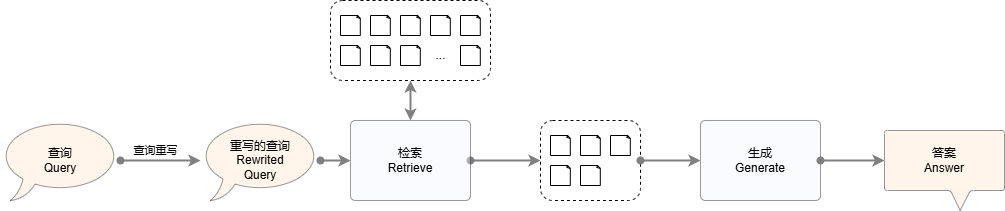

图1：使用查询重写机制的RAG系统图

具体来说，查询重写策略可以细分成“查询扩写”、“子问题查询”、“多步骤查询”三类。具体介绍如下：

#### 1.1 查询扩写

用户查询常常信息不足或存在歧义，影响检索效果。查询扩写通过同义词补充、上下文补全、模板转换等方式，使查询更清晰具体，从而提升准确率和召回率。

[代码GitHub链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter7/query_rewrite.py#L1)

In [ ]:
# 子问题查询
import lazyllm
from lazyllm import Document, ChatPrompter, Retriever

rewrite_prompt = "你是一个查询改写写助手，将用户的查询改写的更加清晰。\
                注意，你不需要对问题进行回答，只需要对原始问题进行改写。\
                下面是一个简单的例子：\
                输入：RAG\
                输出：为我介绍下RAG。\
                    \
                用户输入为："

# prompt设计
robot_prompt = "你是一个友好的 AI 问答助手，你需要根据给定的上下文和问题提供答察。\
                根据以下资料回答问题：\
                {context_str} \n"

# 加载文档库，定义检索器在线大模型，
documents = Document(dataset_path="/mnt/lustre/share_data/dist/cmrc2018/data_kb")  # 请在 dataset_path 传入数据集绝对路径
retriever = Retriever(doc=documents, group_name="CoarseChunk", similarity="bm25_chinese", topk=3)  # 定义检索组件
llm = lazyllm.OnlineChatModule(source='qwen', model='qwen-turbo')  # 调用大模型

llm.prompt(ChatPrompter(instrusction=robot_prompt, extra_keys=['context_str']))
query = "MIT OpenCourseWare是啥？"

query_rewriter = llm.share(ChatPrompter(instruction=rewrite_prompt))
query = query_rewriter(query)
print(f"改写后的查询：\n{query}")

doc_node_list = retriever(query=query)

# 将查询和召回节点中的内容组成dict，作为大模型的输入
res = llm({"query": query, "context_str": "".join([node.get_content() for node in doc_node_list])})

print('\n回答: ', res)

#### 1.2 子问题查询

将主问题拆解为多个子问题，有助于系统从不同角度理解问题并生成更全面的答案。每个子问题单独检索，最后合并答案。适用于抽象或复合型查询，但需注意处理性能开销。您可以通过以下代码实现简单的查询重写：

In [ ]:
import lazyllm

llm = lazyllm.OnlineChatModule()
prompt = "你是一个查询重写助手，如果用户查询较为抽象或笼统，将其分解为多个角度的具体问题。\
          注意，你不需要进行回答，只需要根据问题的字面进行子问题拆分，输出不要超过3条.\
          下面是一个简单的例子：\
          输入：RAG是什么？\
          输出：RAG的定义是什么？\
               RAG是什么领域内的名词？\
               RAG有什么特点？"

query_rewriter = llm.prompt(lazyllm.ChatPrompter(instruction=prompt))
print(query_rewriter("有哪些健康饮食的建议"))

对应的输出应大致为（根据使用的模型及参数的不同内容会有一定差异）：

```bash
1. 健康饮食的基本原则是什么？
2. 如何合理安排一日三餐？
3. 健康饮食中应该包含哪些食物类别及其比例？
```

将上述查询重写策略应用至实战1最基础的 RAG，可以得到如下所示代码，其中高亮部分为新增代码：

In [ ]:
from lazyllm import TrainableModule, Document, ChatPrompter, Retriever, deploy

# prompt设计
rewrite_prompt = "你是一个查询重写助手，将用户查询分解为多个角度的具体问题。\
          注意，你不需要对问题进行回答，只需要根据问题的字面意思进行子问题拆分，输出不要超过 3 条.\
          下面是一个简单的例子：\
          输入：RAG是什么？\
          输出：RAG的定义是什么？\
               RAG是什么领域内的名词？\
               RAG有什么特点？\
               \
          用户输入为："
robot_prompt = '你是一个友好的 AI 问答助手，你需要根据给定的上下文和问题提供答案。\
                根据以下资料回答问题：\
                {context_str} \n '

# 加载文档库，定义检索器在线大模型，
documents = Document(dataset_path="/path/to/your/document") # 请在 dataset_path 传入数据集绝对路径
retriever = Retriever(doc=documents, group_name="CoarseChunk", similarity="bm25_chinese", topk=3) # 定义检索组件
llm = TrainableModule('internlm2-chat-20b').deploy_method(deploy.Vllm).start() # 调用大模型

query_rewriter = llm.share(ChatPrompter(instruction=rewrite_prompt)) # 定义查询重写llm
robot = llm.share(ChatPrompter(instruction=robot_prompt, extra_keys=['context_str'])) # 定义问答llm

# 推理
query = "MIT OpenCourseWare是啥？"
queries = query_rewriter(query) # 执行查询重写
queries_list = queries.split('\n')
retrieved_docs = set()
for q in queries_list: # 对每条重写后的查询进行检索
    doc_node_list = retriever(q)
    retrieved_docs.update(doc_node_list)

# 将查询和召回节点中的内容组成dict，作为大模型的输入
res = robot({"query": query, "context_str": "\n".join([node.get_content() for node in retrieved_docs])})

# 打印结果
print('\n重写的查询：', queries)
print('\n系统答案: ', res)

[相关视频：video/1_query_rewrite.mkv](video/1_query_rewrite.mp4)

#### 1.3 多步骤查询

将复杂问题拆解为连续的多个步骤，每一步依赖上一步的答案推进。适合需要多轮推理的场景，能有效提升对复杂问题的处理能力。具体代码如下：


[代码GitHub链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter7/rag_with_all_strategy.py#L1)

In [ ]:
import lazyllm
from lazyllm import Document, ChatPrompter, Retriever

# prompt设计
rewrite_prompt = "你是一个查询改写助手，将用户的查询改写的更加清晰。\
          注意，你不需要对问题进行回答，只需要对原问题进行改写.\
          下面是一个简单的例子：\
          输入：RAG\
          输出：为我介绍下RAG\
          用户输入为："

judge_prompt = "你是一个判别助手，用于判断某个回答能否解决对应的问题。如果回答可以解决问题，则输出True，否则输出False。 \
            注意，你的输出只能是True或者False。不要带有任何其他输出。 \
            当前回答为{context_str} \n"

robot_prompt = '你是一个友好的 AI 问答助手，你需要根据给定的上下文和问题提供答案。\
                根据以下资料回答问题：\
                {context_str} \n '

# 加载文档库，定义检索器在线大模型，
documents = Document(dataset_path="/mnt/lustre/share_data/dist/cmrc2018/data_kb")
retriever = Retriever(doc=documents, group_name="CoarseChunk", similarity="bm25_chinese", topk=3)
llm = lazyllm.OnlineChatModule(source='qwen', model='qwen-turbo')

# 重写查询的LLM
rewrite_robot = llm.share(ChatPrompter(instruction=rewrite_prompt))

# 根据问题和查询结果进行回答的LLM
robot = llm.share(ChatPrompter(instruction=robot_prompt, extra_keys=['context_str']))

# 用于判断当前回复是否满足query要求的LLM
judge_robot = llm.share(ChatPrompter(instruction=judge_prompt, extra_keys=['context_str']))

# 推理
query = "MIT OpenCourseWare是啥？"

LLM_JUDGE = False
while LLM_JUDGE is not True:
    query_rewrite = rewrite_robot(query)                # 执行查询重写
    print('\n重写的查询：', query_rewrite)

    doc_node_list = retriever(query_rewrite)            # 得到重写后的查询结果
    res = robot({"query": query_rewrite, "context_str": "\n".join([node.get_content() for node in doc_node_list])})

    # 判断判断当前回复是否能满足query要求
    LLM_JUDGE = bool(judge_robot({"query": query, "context_str": res}))
    print(f"\nLLM判断结果：{LLM_JUDGE}")

# 打印结果
print('\n最终回复: ', res)

### 2. 检索策略优化——Retriever

LazyLLM 中的 Retriever 满足 ：

$$
\text{Retriever} = \text{Node Group} \times \text{Similarity} \times \text{Index}
$$


其中，Node Group 表示对原始文档按某种规则划分后的子集形式，例如通过固定长度切分可生成多个子段，或通过摘要提取获取每段的摘要内容。Similarity 是 Retriever 用于衡量节点与用户查询相关性的标准，不同方式适用于不同文档表征，如 BM25 适合基于原文统计，Cosine 更适用于向量表达。Index 则主要影响检索的速度和底层效率，此处不作展开。

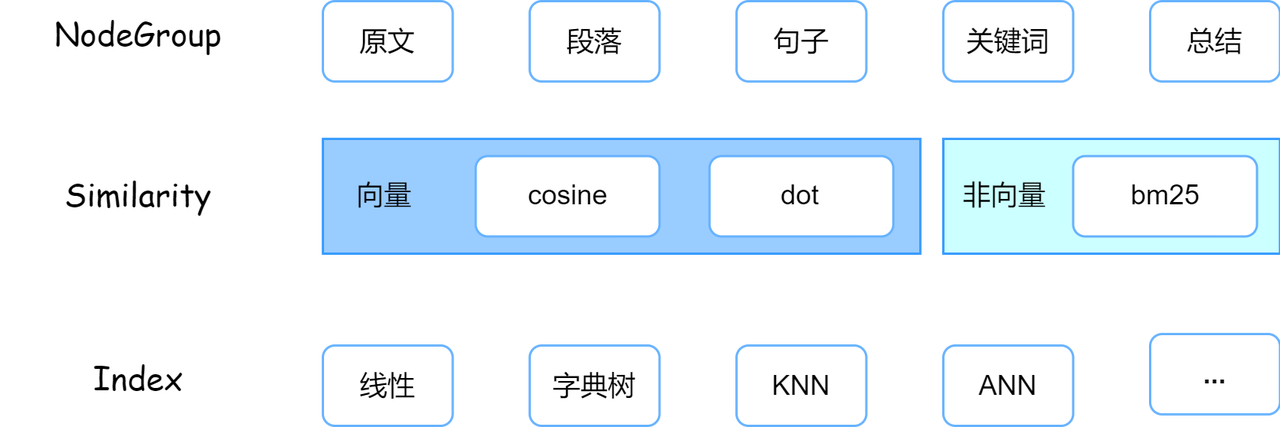

Node Group 决定检索的最小单元，Similarity 控制相关性判断方式，Index 则决定检索性能，三者协同配合共同影响最终召回效果。

#### 2.1 Node Group

LazyLLM 对文档的解析流程如下所示，首先 Loader 会从文件系统读取文件，具体来说Loader 会调用对应文件格式的 Reader 进行读取，例如 txt 文件和 docx 文件需要通过不同的 Reader 实现读取；进行文档读取时会根据文档类型进行相应的解析（即parsing），这一步将按特定规则对完整文档进行解析得到 RAG 友好的格式，例如对 html 等标记语言进行标签清洗提升正文内容的有效性；最后对每个节点应用同样的 Node Transform 构造出一个节点组（node group），应用多个规则则可以构造出多个节点组。图2 展示了 LazyLLM 从文件系统读取文件到最终构造出节点组的数据链路。

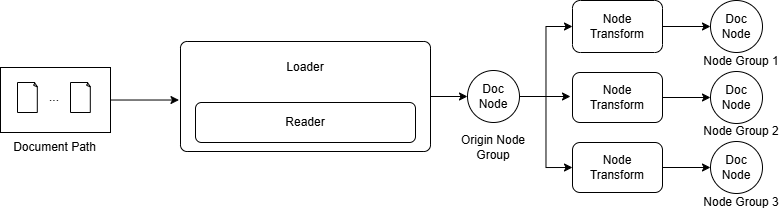

图2：LazyLLM 的 RAG 文档解析与节点组构造链路

LazyLLM 内置了多种格式的 Reader 对不同格式的文件读取进行支持，使用时您只需传入对应的数据路径即可，LazyLLM 会根据文件类型自行选择对应的 Reader 进行文件读取和解析。到这一步为止，文档还是以大段长文本的的形式存在，即图2 中的 Origin Node Group，每个节点存储的是原文。得到 Origin Node Group 之后可以通过 Node Transform 对每个节点进行解析，实现从一个节点到一个（多个）节点的映射，得到一组新的 Node Group。新的 Node Group 中每个节点存储的都是一个文本片段（或摘要等），每个节点除了这些文段内容，还保存了当前节点的父节点、子节点、文档对应的元数据等信息，这些信息在检索时也可以称为重要的辅助信息。详细属性和访问方式您可以参考附录。

下面一起看一个例子，体会一下 LazyLLM 的文档读取与节点解析。假设有 2 个 txt 文件，分别存储了以下内容：

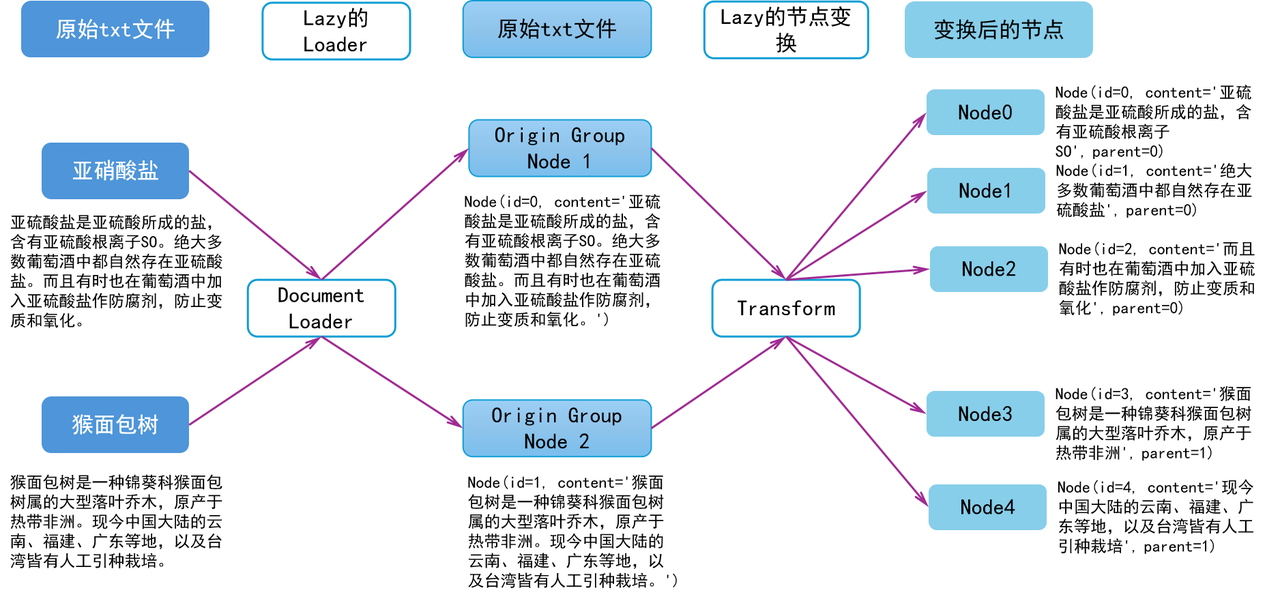

> 1. 亚硫酸盐是亚硫酸所成的盐，含有亚硫酸根离子SO。绝大多数葡萄酒中都自然存在亚硫酸盐。而且有时也在葡萄酒中加入亚硫酸盐作防腐剂，防止变质和氧化。
> 2. 猴面包树是一种锦葵科猴面包树属的大型落叶乔木，原产于热带非洲。现今中国大陆的云南、福建、广东等地，以及台湾皆有人工引种栽培。

则经过文件读取和解析后 Origin Node Group 中有两个 Node，内容为对应文件里的内容。我们假设 id 分别为 1 和 2，应当得到如下所示两个节点（此处忽略了其他属性，只保留了 id 和 content 方便解释 Node Transform）：

> Node(id=0, content='亚硫酸盐是亚硫酸所成的盐，含有亚硫酸根离子SO。绝大多数葡萄酒中都自然存在亚硫酸盐。而且有时也在葡萄酒中加入亚硫酸盐作防腐剂，防止变质和氧化。')
> 
> Node(id=1, content='猴面包树是一种锦葵科猴面包树属的大型落叶乔木，原产于热带非洲。现今中国大陆的云南、福建、广东等地，以及台湾皆有人工引种栽培。')

对上述节点进行以句号为分隔符的分块，并命名新的节点组为“block”，则“block”节点组包含如下所示的节点，其中 parent 存储的是当前节点的父节点，即来源于哪个文段，通过这种节点关系可以实现检索句子返回原文：

> Node(id=0,  content='亚硫酸盐是亚硫酸所成的盐，含有亚硫酸根离子SO', parent=0)
> 
> Node(id=1,  content='绝大多数葡萄酒中都自然存在亚硫酸盐', parent=0)
> 
> Node(id=2,  content='而且有时也在葡萄酒中加入亚硫酸盐作防腐剂，防止变质和氧化', parent=0)
> 
> Node(id=3,  content='猴面包树是一种锦葵科猴面包树属的大型落叶乔木，原产于热带非洲', parent=1)
> 
> Node(id=4,  content='现今中国大陆的云南、福建、广东等地，以及台湾皆有人工引种栽培', parent=1)

使用 LazyLLM 进行召回时，会选择一组 nodes（根据节点组名称）执行检索动作。在召回时，如果发现没有对应的 nodes，则会根据注册的变换规则创建对应的nodes。召回时只会对给定的 nodes 进行召回，从召回到的 nodes 可以找到其关联的祖先节点或子孙节点：

* 例如召回到了 block-1 和 block-3，要找原文对应的节点（即 origin，父节点），已知block-1对应origin-0，block-3对应origin-1，于是通过`document.find('origin')([block-1, block-3])`得到的结果为 [origin-0, origin-1]；
* 例如召回到了 origin-1 ，要找子孙节点（即block，子节点），则会找到其关联的全部节点。已知origin-0对应block[0, 1, 2]，origin-1对应block[3, 4]，于是`document.find('block')([origin-1])`结果为 [block-3，block-4]。

##### 创建内置规则节点组

我们在进阶1 内容中提到长文本不利于检索，因此需要根据这些长文本利用一定的规则构建节点组。LazyLLM 通过 Document.create\_node\_group() 接口创建新的节点组，具体来说通过传入以下几个参数实现​**节点组构造​**​：

* name （str, default: None）: 新的节点组的名称
* transform（Callable）： 节点组解析规则，函数原型是 `(DocNode, group_name, **kwargs) -> List[DocNode]`。LazyLLM 内置了 SentenceSplitter，用户也传入可调用对象实现自定义转换规则。
* parent（str, default: LAZY\_ROOT\_NAME）：基于哪个节点组进行解析，默认情况下基于全文节点组（即上文提到的 origin）进行构造，用户可以指定该参数实现更高效的节点组构造
* trans\_node（bool, default: None ) 决定了 transform 的输入和输出是 DocNode 还是 str ，默认为None。只有在 transform 为 Callable 时才可以设置为true。
* num\_workers（int，default：0）：Transform时所用的新线程数量，默认为0
* kwargs：和具体实现相关的参数，会透传至 transform 函数。

document.create\_node\_group 注册的是从一组 Nodes 到另一组 Nodes 的变换规则，不会直接生成对应的nodes。这个我们称之为LazyInit，这个特性非常重要，因为我们无法保证实例化Document的进程和提供Document查询服务的进程是同一个。

1. 所有的Nodes都是在第一次被使用的时候被创建。假设我们现在需要使用count，此时名为count的nodes还没有被创建，则会查找注册表，了解到count是由sentence变换得到的，因此我们去查找sentence。如果sentence已经被创建，则可以直接使用；否则我们会查找注册表，了解到sentence是由block变换得到的，因此我们去查找block。以此类推，直到找到一个已经被创建的节点，或者到根节点。
2. 每次创建时会一次性把这个document对象下管理的所有文档的同一 name 的 nodes 全部创建。
3. 如果没有根节点的话，则会通过loader去内存中读取和解析原始文档。
4. Node 的 content 可能是一个字符串，也可能是一个 embedding 之后的 byte-code，也可能是一个用户自定义的数据结构（如果不能被similarity识别就在检索召回时报错）。

特别地，为了避免用户的重复劳动，LazyLLM **内置**了一些常用的解析规则为内置的 NodeTransform，所有的document 都可以直接看到和使用，用户无需重复定义：

* SentenceSplitter：输入 chunk\_size 和 chunk\_overlap 参数实现任意固定长度的分块
* LLMParser：通过大模型对文本进行转换，提取关键词，摘要或者问答对。

并且 LazyLLM 提供了三个​**预置节点组**​：

* CoarseChunk：块大小为 1024，重合长度为 100
* MediumChunk： 块大小为 256，重合长度为 25
* FineChunk: 块大小为 128，重合长度为 12

下面这段代码展示了使用内置的 SentenceSplitter 创建节点组，以及使用预置节点组进行检索：

[代码GitHub链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter7/use_builtin_transform.py#L1)

In [ ]:
from lazyllm import Document, Retriever, SentenceSplitter

docs = Document("/mnt/lustre/share_data/dist/cmrc2018/data_kb")

# 使用内置 SentenceSplitter 创建新的 node group
# 此处 chunk_size 和 chunk_overlap 会透传给 SentenceSplitter
# 最终输出的分块规则为 长度为 512，重叠为 64
docs.create_node_group(name='512Chunk', transform=SentenceSplitter, chunk_size=512, chunk_overlap=64)

# 查看节点组内容，此处我们通过一个检索器召回一个节点并打印其中的内容，后续都通过这个方式实现
group_names = ["CoarseChunk", "MediumChunk", "FineChunk", "512Chunk"]
for group_name in group_names:
    retriever = Retriever(docs, group_name=group_name, similarity="bm25_chinese", topk=1)
    node = retriever("亚硫酸盐有什么作用？")
    print(f"======= {group_name} =====")
    print(node[0].get_content())

[相关视频：video/2_0_use_builtin_transform.mp4](video/2_0_use_builtin_transform.mp4)

##### 自定义Transform函数

当内置 Node Transform 不满足需求时，用户依然可以灵活的注册新的 transform 函数。我们已知 create\_node\_group 接收的 transform 是 Callable 一个对象，推荐的形式有：

* 函数
* 定义了 \_\_call\_\_ 方法的类
* 匿名函数（lambda函数）

在实现上述规则时您可以根据自己的需求，设置 create\_node\_group 接口的 trans\_node 为 True 接收 DocNode，默认为 False。下方代码定义了几种可传入的 Node Transform，实现的都是基于句号对文档进行分块：

[代码GitHub链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter7/diy_transform.py#L1)

In [ ]:
from typing import List, Union
from lazyllm import Document, Retriever
from lazyllm.tools.rag.doc_node import DocNode

docs = Document("/path/to/your/documents")

# 第一种：函数实现直接对字符串进行分块规则
def split_by_sentence1(node: str, **kwargs) -> List[str]:
    """函数接收字符串，返回字符串列表，输入为trans_node=False时调用"""
    return node.split('。')
docs.create_node_group(name='block1', transform=split_by_sentence1)

# 第二种：函数实现获取DocNode对应文本内容后进行分块，并构造DocNode
# 适用于返回非朴素DocNode，例如LazyLLM提供了ImageDocNode等特殊DocNode
def split_by_sentence2(node: DocNode, **kwargs) -> List[DocNode]:
    """函数接收DocNode，返回DocNode列表，输入为trans_node=False时调用"""
    content = node.get_text()
    nodes = []
    for text in content.split('。'):
        nodes.append(DocNode(text=text))
    return nodes
docs.create_node_group(name='block2', transform=split_by_sentence2, trans_node=True)

# 第三种：实现了 __call__ 函数的类
# 优点是一个类用于多种分块，例如这个例子可以通过控制实例化时的参数实现基于多种符号的分块
class SymbolSplitter:
    """实例化后传入Transform，默认情况下接收字符串，trans_node为true时接收DocNode"""
    def __init__(self, splitter="。", trans_node=False):
        self._splitter = splitter
        self._trans_node = trans_node
    
    def __call__(self, node: Union[str, DocNode]) -> List[Union[str, DocNode]]:
        if self._trans_node:
            return node.get_text().split(self._splitter)
        return node.split(self._splitter)

sentence_splitter_1 = SymbolSplitter()
docs.create_node_group(name='block3', transform=sentence_splitter_1)

# 指定传入 DocNode
sentence_splitter_2 = SymbolSplitter(trans_node=True)
docs.create_node_group(name='block4', transform=sentence_splitter_2, trans_node=True)

# 指定分割符号为 \n
paragraph_splitter = SymbolSplitter(splitter="\n")
docs.create_node_group(name='block5', transform=paragraph_splitter)

# 第四种：直接传入lambda函数，适用于简单规则情况
docs.create_node_group(name='block6', transform=lambda b: b.split('。'))

# 查看节点组内容，此处我们通过一个检索器召回一个节点并打印其中的内容，后续都通过这个方式实现
for i in range(6):
    group_name = f'block{i+1}'
    retriever = Retriever(docs, group_name=group_name, similarity="bm25_chinese", topk=1)
    node = retriever("亚硫酸盐有什么作用？")
    print(f"======= {group_name} =====")
    print(node[0].get_content())

[相关视频：video/2_1_diy_transform.mp4](video/2_1_diy_transform.mp4)

##### 大小块策略

LazyLLM还提供了以下功能：当召回到某个节点时，您不仅可以取出该节点的内容，还可以取出该节点的父节点。即通过小块召回大块。具体代码如下：

In [ ]:
import lazyllm
from lazyllm import bind
from lazyllm import Document, Retriever, TrainableModule

llm = lazyllm.OnlineChatModule(source='qwen', model='qwen-turbo')
prompt = '你是一个友好的 AI 问答助手，你需要根据给定的上下文和问题提供答案。\
          根据以下资料回答问题：\
          {context_str} \n '

robot = llm.prompt(lazyllm.ChatPrompter(instruction=prompt, extra_keys=['context_str']))

# 文档加载
docs = Document("/mnt/lustre/share_data/dist/cmrc2018/data_kb")
docs.create_node_group(name='sentences', transform=(lambda d: d.split('\n') if d else ''), parent=Document.CoarseChunk)

# 定义两个不同的检索器在同一个节点组使用不同相似度方法进行检索
retriever = Retriever(docs, group_name="sentences", similarity="bm25_chinese", topk=3)

# 执行查询
query = "都有谁参加了2008年的奥运会？"

# 原节点检索结果
doc_node_list = retriever(query=query)
doc_node_res = "".join([node.get_content() for node in doc_node_list])
print(f"原节点检索结果：\n{doc_node_res}")
print('='*100)

# 父节点对应结果
parent_list = [node.parent.get_text() for node in doc_node_list]
print(f"父节点检索结果：\n{''.join(parent_list)}")
print('='*100)

# 将query和召回节点中的内容组成dict，作为大模型的输入
res = robot({"query": query, "context_str": "".join([node_text for node_text in parent_list])})

print("系统答案：\n", res)

##### 特殊的节点组

除了上述固定长度分块方法，LazyLLM 提供了 LLMParser 可以实现基于 LLM 对文档进行解析的操作，支持三种模式：

* 摘要提取（summary）：对文段内容进行分析，提炼出核心信息，生成简洁且能代表全文主旨的摘要，帮助用户快速获取关键信息。
* 关键词提取（keyword）：自动从文段中识别出最具代表性的关键词，以便后续检索、分类或分析。
* QA对提取：从文段中自动抽取多个问答对，匹配与用户查询相似的问题，从而提供预设答案。这些问答对可以用于问答系统、知识库建设或生成式 AI 组件的参考，以提高信息获取的效率和准确性。

[完整GitHub代码链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter7/use_llmparser.py#L1)

In [ ]:
import lazyllm

# 请您在运行脚本前将您要使用的在线模型 Api-key 抛出为环境变量，或更改为本地模型
llm = OnlineChatModule()

# LLMParser 是 LazyLLM 内置的基于 LLM 进行节点组构造的类，支持 summary，keywords和qa三种
summary_llm = LLMParser(llm, language="zh", task_type="summary") # 摘要提取LLM
keyword_llm = LLMParser(llm, language="zh", task_type="keywords") # 关键词提取LLM
qapair_llm = LLMParser(llm, language="zh", task_type="qa") # 问答对提取LLM
# 您可以通过下方代码查看新的节点信息 
# nodes = qa_parser(DocNode(text=file_text)) 

# 利用 LLMParser 创建节点组
docs = Document("/path/to/your/doc/")

docs.create_node_group(name='summary', transform=lambda d: summary_llm(d), trans_node=True)
docs.create_node_group(name='keyword', transform=lambda d: keyword_llm(d), trans_node=True)
docs.create_node_group(name='qapair', transform=lambda d: qapair_llm(d), trans_node=True)

# 查看节点组内容，此处我们通过一个检索器召回一个节点并打印其中的内容，后续都通过这个方式实现
group_names = ["CoarseChunk", "summary", "keyword", "qapair"]
for group_name in group_names:
    retriever = Retriever(docs, group_name=group_name, similarity="bm25_chinese", topk=1)
    node = retriever("亚硫酸盐有什么作用？")
    print(f"======= {group_name} =====")
    print(node[0].get_content())

[相关视频：video/2_2_use_llmparsre.mp4](video/2_2_use_llmparsre.mp4)

##### 构造复杂的节点组树

相信读者通过上面的例子对 LazyLLM 中的 Node Transform 有了一定的了解，下面我们将定义一个满足如下结构的 Node Group，通过查看这些节点组节点的具体内容分析不同节点组适用的任务场景。每个节点组对应的不同拆分粒度和规则反映了文档不同方面的特征，我们可以通过在不同的场合使用这些特征从而更好地判断文档和用户输入的查询内容的相关性。

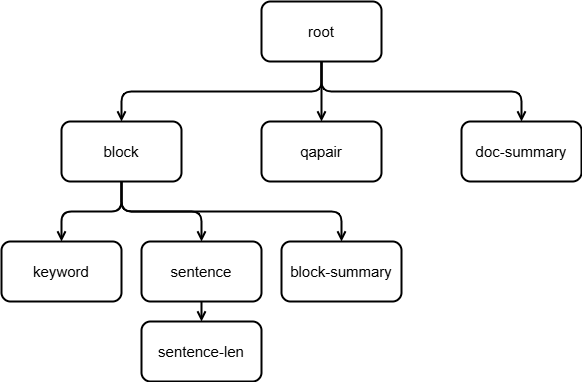

图3 一种复杂的节点组树

| 节点组类型       | 特征                   | 适用场景 |
|------------------|------------------------|----------|
| 粗粒度节点组     | 大段落或章节级拆分     | - 查询主题宽泛（如概述性问答）<br>- 需要上下文连贯性的任务（如摘要生成） |
| 细粒度节点组     | 句子或短语级拆分       | - 精准答案检索（如事实型问答）<br>- 高相关性要求的语义匹配 |
| 逻辑规则节点组   | 按标题、列表、表格等结构化拆分 | - 结构化数据查询（如参数对比、步骤说明）<br>- 多模态文档处理 |

In [ ]:
from lazyllm import OnlineChatModule, Document, LLMParser

# 请您在运行脚本前将您要使用的在线模型 Api-key 抛出为环境变量，或更改为本地模型
llm = OnlineChatModule()

# LLMParser 是 LazyLLM 内置的基于 LLM 进行节点组构造的类，支持 summary，keywords和qa三种
summary_llm = LLMParser(llm, language="zh", task_type="summary") # 摘要提取LLM
keyword_llm = LLMParser(llm, language="zh", task_type="keywords") # 关键词提取LLM
qapair_llm = LLMParser(llm, language="zh", task_type="qa") # 问答对提取LLM

docs = Document("/path/to/your/doc/")

# 以换行符为分割符，将所有文档都拆成了一个个的段落块，每个块是1个Node，这些Node构成了名为"block"的NodeGroup
docs.create_node_group(name='block', transform=lambda d: d.split('\n'))

# 使用一个可以提取问答对的大模型把每个文档的摘要作为一个名为"qapair"的NodeGroup，内容是针对文档的问题和答案对
docs.create_node_group(name='qapair', transform=lambda d: qapair_llm(d), trans_node=True)

# 使用一个可以提取摘要的大模型把每个文档的摘要作为一个名为"doc-summary"的NodeGroup，内容是整个文档的摘要
docs.create_node_group(name='doc-summary', transform=lambda d: summary_llm(d), trans_node=True)

# 在"block"的基础上，通过关键词抽取大模型从每个段落都抽取出一些关键词，每个段落的关键词是一个个的Node，共同组成了"keyword"这个NodeGroup
docs.create_node_group(name='keyword', transform=lambda b: keyword_llm(b), parent='block', trans_node=True)

# 在"block"的基础上进一步转换，使用中文句号作为分割符而得到一个个句子，每个句子都是一个Node，共同构成了"sentence"这个NodeGroup
docs.create_node_group(name='sentence', transform=lambda d: d.split('。'), parent='block')

# 在"block"的基础上，使用可以抽取摘要的大模型对其中的每个Node做处理，从而得到的每个段落摘要的Node，组成"block-summary"
docs.create_node_group(name='block-summary', transform=lambda b: summary_llm(b), parent='block', trans_node=True)

# 在"sentence"的基础上，统计每个句子的长度，得到了一个包含每个句子长度的名为"sentence-len"的NodeGroup
docs.create_node_group(name='sentence-len', transform=lambda s: len(s), parent='sentence')

我们通过下面这段代码在 CMRC 数据集上验证一下不同节点组召回的内容：

In [ ]:
from lazyllm import Retriever
# 您需要在此处更换不同的 group_name 检查对应节点组的效果
retriever = Retriever(docs, group_name="CoarseChunk", similarity="bm25_chinese", topk=1)
node = retriever("国际象棋超级大赛的概况")
print("CoarseChunk节点组：\n", node[0].get_content())

| **节点组**    | **节点信息**                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| --------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| 1024固定长度节点组 | 5mil。敌我识别仪，识别距离30km。MPQ-78有三种型式，雷同天兵防空系统的整合单一车厢型（拖曳式），或是雷达与操作车厢分开的分离型（由两辆悍马车负载）。MPQ-78一次可导控2门地面防砲与4座飞弹发射器／车，可连接捷羚防空飞弹系统(陆基式天剑一型飞弹)等以提升其系统战力。<br><br>中国（南京）国际象棋超级大赛（Pearl Spring Super Tournament）原名中国（南京）国际象棋特级大师邀请赛，首届比赛于2008年12月11日至22日在南京市浦口区明发珍珠泉大酒店举行。本次大赛由南京市人民政府、国家体育总局棋牌运动管理中心主办，浦口区人民政府、南京市体育局承办，康缘药业股份有限公司、扬子晚报、蒙代尔国际企业家大学协办。被国际棋联定为21级赛事，也是亚洲迄今为止举办的最高水平的国际象棋大赛。双循环赛制比赛十轮，12月11日至15日进行前5轮，16日休息，17至21日进行后5轮。每方90分钟，每步棋加30秒。总奖金25万欧元，其中冠军8万欧元，第2至6名依次为5万5千欧元、4万欧元、3万欧元、2万5千欧元、2万欧元。结果托帕洛夫夺得冠军，阿罗尼扬获得亚军，卜祥志获得第三名。2009年2月1日被接纳为大满贯赛事并更名为中国（南京）国际象棋超级大赛。第二届比赛于2009年9月27日-10月9日举行。“康缘药业杯”2010中国(南京)国际象棋超级大赛于2010年10月19-30日举行<br><br>成公英，表字不详，金城人，东汉末群雄韩遂的信任将领。韩遂在潼关之战失败后，逃到湟中，部众四散，唯独成公英跟随。后来韩遂逝世，而成为曹魏的将领。汉灵帝中平末年时，成公英开始跟随韩遂，并成为腹心。建安十六年（211年），马超与韩遂反抗曹操，但韩遂在华阴被打败，逃到湟中，部众四散，只有成公英跟随。当时韩遂女婿阎行意图杀死韩遂投降，于是乘夜攻击韩遂，但失败。韩遂极为失意，向成公英表示自己打算逃到蜀地，投靠刘备。但成公英反对，认为不应放弃韩遂建立多年的基地而投靠他人，建议韩遂投靠羌人，等待机会卷土重来。 |
| 段落节点组         | 中国（南京）国际象棋超级大赛（Pearl Spring Super Tournament）原名中国（南京）国际象棋特级大师邀请赛，首届比赛于2008年12月11日至22日在南京市浦口区明发珍珠泉大酒店举行。本次大赛由南京市人民政府、国家体育总局棋牌运动管理中心主办，浦口区人民政府、南京市体育局承办，康缘药业股份有限公司、扬子晚报、蒙代尔国际企业家大学协办。被国际棋联定为21级赛事，也是亚洲迄今为止举办的最高水平的国际象棋大赛。双循环赛制比赛十轮，12月11日至15日进行前5轮，16日休息，17至21日进行后5轮。每方90分钟，每步棋加30秒。总奖金25万欧元，其中冠军8万欧元，第2至6名依次为5万5千欧元、4万欧元、3万欧元、2万5千欧元、2万欧元。结果托帕洛夫夺得冠军，阿罗尼扬获得亚军，卜祥志获得第三名。2009年2月1日被接纳为大满贯赛事并更名为中国（南京）国际象棋超级大赛。第二届比赛于2009年9月27日-10月9日举行。“康缘药业杯”2010中国(南京)国际象棋超级大赛于2010年10月19-30日举行                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| QA对节点组          | query<br><br>中国（南京）国际象棋超级大赛（Pearl Spring Super Tournament）是由哪些机构主办的？answer：<br><br>南京市人民政府、国家体育总局棋牌运动管理中心主办，浦口区人民政府、南京市体育局承办，康缘药业股份有限公司、扬子晚报、蒙代尔国际企业家大学协办                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| 文档摘要节点组      | 景栋是缅甸掸邦主要城镇，历史悠久，曾是暹罗国土，现为中国、寮国、缅甸及泰国的交通枢纽。市区面积3平方公里，人口约60,000，文化多元，有佛寺和基督教堂。Kyaing Tong Degree College设于此，也是掸族聚集地。历史上，景栋由清迈王朝的孟莱王之孙建立，历经多次战争和政权更迭。《卡美拉 大怪兽空中决战》为1995年日本怪兽电影，是卡美拉系列第9部作品。西奥多·庞维勒是法国诗人、作家，生于1825年，其作品在文学界有重要影响。胜利广场位于巴黎，广场中心有路易十四的骑马雕像，周围为高档街区。蓍是一种多年生草本植物，分布在北半球，其根茎和叶子可入药。猴面包树原产于热带非洲，其果实、叶子和种子有多种用途。拉诺米·克罗莫维焦约是荷兰游泳运动员，多次刷新世界纪录，并在国际比赛中获奖。CS/MPQ-78雷达是中华民国空军的防空雷达系统。中国（南京）国际象棋超级大赛是亚洲最高水平的国际象棋大赛之一。成公英是东汉末年的将领，曾跟随韩遂，后投降曹操，在凉州平乱中表现出色，后病死。                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| 关键词节点组        | 中国(南京)国际象棋超级大赛                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| 句子节点组          | 2009年2月1日被接纳为大满贯赛事并更名为中国（南京）国际象棋超级大赛                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| 段落摘要节点组      | 中国（南京）国际象棋超级大赛简介及历届概况                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |

由上述输出可知，虽然1024固定长度节点组能够保留较长的上下文，但包含与查询无关的内容（例如关于象棋大赛的分块包含成公英的相关内容），影响后续模型提取关键信息的效率，此外片段化处理固定长度，可能会拆分相关信息，使得上下文不完整（例如 MPQ-78 相关内容被分到了两个不同的分块）。段落节点组召回的信息结构清晰，直接与查询主题相关，避免了无关内容的干扰，但当内容分布在多个段落中则可能无法涵盖所有相关主题，适用于段落结构清晰，内容分布集中（技术文档等）的文档检索任务。

QA对节点组可以直接匹配问题，高效获取明确的结构化信息，适用于结构化信息的检索，但仅限于预设的问答对，无法覆盖所有潜在问题，召回覆盖率可能不足，实际中还是需要结合其他节点组实现更全面的检索。文档摘要节点组的信息高度浓缩，能够快速定位文段核心特点，减少无关信息干扰，适用于查询高级概念，但细节信息缺失，无法回答具体问题，且依赖于摘要质量，若摘要未覆盖关键内容，可能影响召回效果。关键词节点组的召回精准度高，能够直接匹配核心关键词，确保主题相关性，适用于模糊查询的情况下，确保相关内容不会被遗漏。但劣势是丢失上下文信息，导致模型无法理解关键词间的逻辑关系，适用于通过精确的关键词进行搜索的场景，也可以结合大模型提取关键词使用。

句子节点组的粒度最小，信息直接，可用于精准检索，适用于事实性较强的查询，避免信息冗余。但缺点是过于碎片化，难以提供上下文，可能需要多个句子组合才能回答完整问题，召回时可能遗漏其他相关信息。通常法律法规等文档中一个句子包含的信息量非常大，非常适合用句子节点组进行检索。段落摘要节点组适用于高层次的概述性问题，但细节覆盖不够全面，依赖摘要算法，通常可以用于用摘要召回长段落（例如技术文档）。利用摘要或关键词节点组召回其父节点组的方法：

In [ ]:
from lazyllm import Retriever
# 您需要在此处更换不同的 group_name 检查对应节点组的效果
retriever = Retriever(docs, group_name="block-summary", similarity="bm25_chinese", topk=1)
node = retriever("国际象棋超级大赛的概况")
print("CoarseChunk节点组：\n", node[0].parent.get_content())

在实际应用中通常是选择上述几种节点组中的多个节点组进行混合检索，召回多组信息后进行拼接等后处理获取更全面、准确的上下文。

##### RAG 中使用多节点组

在 RAG 系统中使用节点组并召回对应节点组的方式如下方代码所示，其中高亮部分为与最简单的 RAG 相比新增的代码，修改对应创建方法和检索节点组名称即可实现在不同节点组进行召回的目的。

[完整GitHub代码链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter7/rag_multi_node_group.py#L1)

In [ ]:
import lazyllm

# 使用在线大模型
# 请在使用前抛出对应厂商API-key为环境变量
llm = lazyllm.OnlineChatModule()

# 文档加载
documents = lazyllm.Document(dataset_path="/mnt/lustre/share_data/dist/cmrc2018/data_kb")
documents.create_node_group(name='sentences', transform=lambda b: b.split('。'))
documents.create_node_group(name='block', transform=lambda b: b.split('\n'))

# 检索组件定义
retriever1 = lazyllm.Retriever(doc=documents, group_name="block", similarity="bm25_chinese", topk=3) 
retriever2 = lazyllm.Retriever(doc=documents, group_name="sentences", similarity="bm25_chinese", topk=3) 

# prompt 设计
prompt = '你是一个友好的 AI 问答助手，你需要根据给定的上下文和问题提供答案。\
          根据以下资料回答问题：\
          {context_str} \n '
robot = llm.prompt(lazyllm.ChatPrompter(instruction=prompt, extra_keys=['context_str']))

# 推理
query = "亚硫酸盐有什么作用？"
# 将Retriever组件召回的节点全部存储到列表doc_node_list中
doc_node_list1 = retriever1(query=query)
doc_node_list2 = retriever2(query=query)

# 将两个检索器的召回结果合并到一个列表
doc_node_list = doc_node_list1 + doc_node_list2

# 将query和召回节点中的内容组成dict，作为大模型的输入
res = robot({"query": query, "context_str": "".join([node.get_content() for node in doc_node_list])})

print("系统答案：", res)

[相关视频：video/2_use_node_group.mp4](video/2_use_node_group.mp4)

##### 节点组对评估的影响

节点组影响最终召回的上下文内容，太长可能会导致冗余内容比有效内容更多，太短则可能出现无法覆盖查询相关内容的情况。表2 展示了使用不同节点组进行召回的内容命中率和上下文相关性指标。具体来说，使用 CMRC-test 中的 1002 个问题，在多个节点组通过 bm25 算法进行检索，最后计算每个节点组召回结果 top1，top3，top5 文档的命中率（正确召回问题对应的上下文）和召回文档的上下文相关性，两者指标均为越高越好。由于存在多种分段手法无法满足直接计算段落 id，因此计算命中率的方法是召回文段与参考文段之间的编辑距离（字符串 a 修改多少个字符后可以变成 b）小于 0.5。

表2：使用不同节点组召回的结果对比。（recall ↑ / context relevance ↑）

| 节点组类型           | top 1       | top 3       | top 5       |
|----------------------|-------------|-------------|-------------|
| 固定长度（1024）节点组 | 0.43 / 0.50 | 0.47 / 0.20 | 0.48 / 0.12 |
| 通过摘要召回段落     | 0.83 / 0.76 | 0.89 / 0.29 | 0.90 / 0.17 |
| 自定义段落节点组     | 0.94 / 0.86 | 0.97 / 0.30 | 0.98 / 0.18 |

由上表可知在当前任务中使用段落节点组的召回效果是最好的，但上下文相关性随着召top k取值越高，呈现明显的下降趋势。这是因为上下文相关性计算的是在召回的文档中，与查询相关的句子比例是多少，在当前任务中，每个段落的内容相互独立，因此当召回多个段落时冗余内容的比例增加是符合现实预期的。

需要注意由于文档库的类型和内容差异，不同的文档库、不同类型的文档内容适用的节点组会有所不同。例如对于本课程构造的 CMRC 文档库而言，每个段落的内容相互独立，因此段落分块有助于完整召回问题的上下文，对于法律法规等每个句子包含大量信息量，且每个句子描述的内容可能相互独立的文档来说，句子节点组是更优的选择。因此具体任务中使用何种节点组进行检索召回需要通过观察文档库特点并结合实际召回表现进行选择。

#### 2.2 Similarity

在 RAG 系统中，相似度计算方法是检索阶段的核心部分，它决定了查询与文档之间的相关性，从而影响最终生成的答案质量。主要的相似度计算方法包括稀疏向量方法和稠密向量方法，以及混合检索等方式。LazyLLM 原生支持 cosine 相似度和 bm25 相似度，您只需在检索时传入对应方法的名称指定您要使用哪种相似度计算方式即可。如果您需要自定义相似度函数，请参考选修2 自定义召回策略相关组件教程。

下文先介绍 LazyLLM 中使用 Embedding 的方式，因为 cosine 检索需要对文档进行 Embedding 后才能进行计算。然后介绍使用 LazyLLM 内置的 cosine 和 bm25 进行文档检索的使用方法和简单对比，进而引入使用多 embedding 进行召回，最后介绍通过相似度阈值过滤掉多余的不相关文档的方法。

##### Embedding 的使用

Embedding 是一种将文档映射为一个保留原文语义的高维向量的技术，基于这种高维向量可以高效进行语义检索。目前通常使用基于 BERT 的 Embedding 模型对文档进行向量化得到稠密的向量表示。LazyLLM 支持调用线上和线下 Embedding 模型，其中线上模型通过 OnlineEmbeddingModule 调用，线下模型通过 TrainableModule 调用。

OnlineEmbeddingModule 用来管理创建目前市面上的在线Embedding服务模块，可配置参数有：

* source (str) – 指定要创建的模块类型，可选为 openai / sensenova / glm / qwen / doubao
* embed\_url (str) – 指定要访问的平台的基础链接，默认是官方链接
* embed\_model\_name (str) – 指定要访问的模型，默认值为 text-embedding-ada-002(openai) / nova-embedding-stable(sensenova) / embedding-2(glm) / text-embedding-v1(qwen) / doubao-embedding-text-240715(doubao)
  
  使用 TrainableModule 启动本地服务可配置参数有：
* base\_model (str, default: '' ) – 基模型的名称或者路径，如果本地没有模型，则会尝试下载。这里需要您注意的是您需要传入模型的绝对路径，或者指定模型路径为环境变量 LAZYLLM\_MODEL\_PATH 后在此处传入模型名。

目前而言常用的 Embedding 模型通常是 jina 系列或 bge 系列的模型（例如 bge-large-zh-v1.5，bge-m3 等），具体模型名称可以在 huggingface 检索得到。在线 embedding 模型提供的 embedding 模型需要在指定厂商的模型列表进行查找，如果没有特定需求，您可以直接使用LazyLLM OnlineEmbeddingModule 提供的默认模型即可。

下面是使用LazyLLM调用在线Embedding模型和启动本地服务并调用的示例代码：

In [ ]:
from lazyllm import OnlineEmbeddingModule, TrainableModule, deploy

# 将您的在线模型 API key 抛出为环境变量，以 sensenova 为例
#     export LAZYLLM_SENSENOVA_API_KEY=     
#     export LAZYLLM_SENSENOVA_SECRET_KEY=
online_embed = OnlineEmbeddingModule("sensenova")

# 将您的本地模型地址抛出为环境变量：
#     export LAZYLLM_MODEL_PATH=/path/to/your/models
offline_embed = TrainableModule('bge-large-zh-v1.5').start()
# 或者使用绝对路径：
offline_embed = TrainableModule('/path/to/your/bge-large-zh-v1.5').start()

# 启动稀疏嵌入模型，目前仅支持 bge-m3
offline_sparse_embed = TrainableModule('bge-m3').deploy_method(
            (deploy.AutoDeploy, 
            {'embed_type': 'sparse'})).start()

print("online embed: ", online_embed("hello world"))
print("offline embed: ", offline_embed("hello world"))
print("offline sparse embed: ",  offline_sparse_embed("hello world"))

上述代码输出应当为：

```bash
online embed: [0.0010528564, 0.0063285828, 0.0049476624, -0.012008667,..., -0.051696777]

offline embed: [-0.02584601193666458, -0.0014020242961123586,..., 0.016336631029844284]

offline sparse embed: {"33600": 0.22412918508052826, "31": 0.20403659343719482, "8999": 0.2736259400844574}
```

注：不同模型生成的 Embedding 有所差异是正常的。

如果您部署了一个在线 Embedding 服务，当接口格式与OnlineEmbeddingModule 的 source 参数接收的五个厂商的在线服务一致时，可以直接将 embed\_url 改为您自己的服务地址使用，如果不一致则可以通过继承 OnlineEmbeddingModuleBase 访问自定义 Embedding 服务，下面是一段示例代码。

In [ ]:
from lazyllm.module import OnlineEmbeddingModuleBase

# 配置新平台支持的api_key到全局变量
# 通过lazyllm.config.add(变量名，类型，默认值，环境变量名)进行添加
class CustomOnlineEmbeddingModule(OnlineEmbeddingModuleBase):
    def __init__(self, embed_url: str = '<new platform embedding url>',
                 embed_model_name: str = '<new platform embedding model name>'):
        super().__init__("<new_platform_name>", embed_url, lazyllm.config['new_platform_api_key'], embed_model_name)
        
    def _encapsulated_data(self, text:str, **kwargs):
        # 将数据包装为您的服务需要的数据格式
        json_data = {
            "input": [text],
            "model": self._embed_model_name
        }
        if len(kwargs) > 0:
            json_data.update(kwargs)
        return json_data

    def _parse_response(self, response: dict[str, any]):
        # 解析您的服务返回的数据，返回 embedding 部分即可
        return response['embeddings'][0]['embedding']

使用 LazyLLM 为文档进行嵌入时无需手动遍历，只需在实例化 Document 对象时传入上述定义的嵌入模型即可，需要注意的是 LazyLLM 会在指定节点组第一次执行检索时根据指定的相似度是在嵌入上进行计算还是直接在原文进行计算，决定是否对当前节点组进行嵌入。为 Document 指定 Embedding 的方法如下所示：

In [ ]:
import lazyllm

# 定义嵌入模型
online_embed = lazyllm.OnlineEmbeddingModule()

# 加载文档
documents = lazyllm.Document('/path/to/your/document', embed=online_embed)

##### 使用相似度召回文档

学会指定嵌入模型后，我们就可以通过向量相似度进行文档召回了。LazyLLM 原生支持 cosine 相似度进行语义检索。为文档指定 Embedding 后，Retriever 传入参数 similarity=“cosine” 即可。LazyLLM.Retriever 可传入的值有：“cosine”，“bm25”和“bm25\_chinese”，其中只有“cosine”需要为文档指定Embedding。需要注意的是，哪怕为文档指定了 Embedding，但检索时使用 “bm25” 和 “bm25\_chinese” 相似度时并不会进行嵌入计算。下面这段代码展示了使用原生相似度进行召回的例子，并简单对比了 cosine 和 bm25 的的召回特点：

In [ ]:
from lazyllm import Document, Retriever, TrainableModule

# 定义 embedding 模型
embed_model = TrainableModule("bge-large-zh-v1.5").start()

# 文档加载
docs = Document("/path/to/your/document", embed=embed_model)
docs.create_node_group(name='block', transform=(lambda d: d.split('\n')))

# 定义两个不同的检索器在同一个节点组使用不同相似度方法进行检索
retriever1 = Retriever(docs, group_name="block", similarity="cosine", topk=3)
retriever2 = Retriever(docs, group_name="block", similarity="bm25_chinese", topk=3)

# 执行查询
query = "都有谁参加了2008年的奥运会？"
result1 = retriever1(query=query)
result2 = retriever2(query=query)

print("余弦相似度召回结果：")
print("\n\n".join([res.get_content() for res in result1]))
print("bm25召回结果：")
print("\n\n".join([res.get_content() for res in result2]))

[相关视频：video/3_cosine_vs_bm25.mp4](video/3_cosine_vs_bm25.mp4)

下面是二者的召回结果，可见使用不同相似度对召回结果有一定的影响，从查询特点来看，包含“2008年”和“奥运会”两个比较重要的主题，余弦相似度的检索结果同时包含了这两个重要主题。但bm25的结果虽然每条结果都包含“奥运会”的信息，但其中有一个结果并没有提及2008年奥运会。这是因为bm25方法在分词后将2008年的奥运会分为了两个token，在计算时并没有将其视作一个整体的语义信息，所以会有尽管关键词充分，但没有切住主题的问题。

|  | **余弦相似度召回结果**                                                                  | **bm25召回结果**                                                                                                                                                                                      |
| --- | ----------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1 | ...参加2008年北京夏季奥林匹克运动会的中国花样游泳队一行共计15人，其中运动员9人，教练4人...    | ...1996年和2000年夏季奥林匹克运动会两度获得举重项目金牌，为中国奥运史上连续两届获得举重冠军的第一人...参加了亚特兰大奥运会的70公斤级举重比赛...成为该届奥运会的经典一幕。悉尼奥运会后...第三次参加奥运会... |
| 2 | 2008年夏季奥林匹克运动会男子100米跑赛事在2008年8月15日及8月16日在北京国家体育馆举行...       | 2008年8月10日，谭望嵩在北京奥运会中国队与比利时队的男足小组赛当中...                                                                                                                                       |
| 3 | 参加2008年北京夏季奥林匹克运动会的中国皮划艇队共计40人，其中运动员23人，官员与工作人员17人... | ...参加2008年北京夏季奥林匹克运动会的中国花样游泳队一行共计15人，其中运动员9人，教练4人...                                                                                                                  |

##### 多 Embedding 召回

[完整GitHub代码链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter7/use_multi_embed.py#L1)

我们可以对同一文档应用多种 Embedding ，同时使用多个检索器召回得到更好的效果。下面的代码展示了如何在Document 中使用多种 Embedding 的方法，与使用单个 Embedding 模型相比，只需将多个模型构造成一个字典传入即可。

In [ ]:
from lazyllm import OnlineEmbeddingModule, TrainableModule, Document

online_embed = OnlineEmbeddingModule()
offline_embed = TrainableModule('bge-large-zh-v1.5').start()
embeds = {'vec1': online_embed, 'vec2': offline_embed}
doc = Document('/content/doc/', embed=embeds)

LazyLLM 支持对同一个文档应用多个 Embedding，此时我们可以通过对多个 Embedding 执行多次召回的方式提升召回率。LazyLLM 使用多 Embedding 召回的方式如下：

In [ ]:
# 探讨不同embedding对召回率的影响
# 请将您的在线嵌入模型api-key抛出为环境变量或使用本地模型

from lazyllm import Document, Retriever, TrainableModule

# 定义多个 embedding 模型
bge_m3_embed = TrainableModule('bge-m3').start()
bge_large_embed = TrainableModule('bge-large-zh-v1.5').start()
embeds = {'vec1': bge_m3_embed, 'vec2': bge_large_embed}

# 文档加载
docs = Document("/mnt/lustre/share_data/dist/cmrc2018/data_kb", embed=embeds)
docs.create_node_group(name='block', transform=(lambda d: d.split('\n')))

# 定义两个不同的检索器分别对相同节点组的不同 embedding 进行检索 
retriever1 = Retriever(docs, group_name="block", embed_keys=['vec1'], similarity="cosine", topk=3)
retriever2 = Retriever(docs, group_name="block", embed_keys=['vec2'], similarity="cosine", topk=3)

# 执行检索
query = "都有谁参加了2008年的奥运会？"
result1 = retriever1(query=query)
result2 = retriever2(query=query)

print("使用bge-m3进行余弦相似度召回结果：")
print("\n\n".join([res.get_content() for res in result1]))
print("使用bge-large-zh-v1.5进行余弦相似度召回结果：")
print("\n\n".join([res.get_content() for res in result2]))

[相关视频：video/4_multi_embed.mp4](video/4_multi_embed.mp4)

这个例子给出了使用多种 embedding 对同一段文档进行嵌入并检索的方式，与使用单个embedding 的区别主要在于首先传给 Document 的 embed 参数是一个形如 { embed\_key: Callable } 的 python 字典，检索时多传入一个 embed\_keys 参数，为一个字符串列表，其中每一个字符串对应当前检索器进行检索的 embedding 空间，例如对上述例子，如果我们对 vec1 和 vec2 使用的相似度函数以及节点组都是一致的，且对结果没有明确区分的情况下直接输入 ['vec1', 'vec2'] 即可。 需要这样的是，在这种情况下输出的 topk 不是针对每个embed\_key，而是对两者取 topk 后进行去重输出。

In [ ]:
retriever = Retriever(docs, group_name="block", embed_keys=['vec1', 'vec2'], similarity="cosine", topk=3)

##### 使用相似度阈值过滤

通过阈值过滤的方法可以过滤掉相似度过低的节点，提升召回文档的可靠性。例如在没有使用阈值过滤时系统在 topk=6 的时候召回了 6 篇文档，其中相似度依次为 0.9, 0.87, 0.6, 0.31, 0.23, 0.21，通过观察节多我们发现后面的三个文档与查询并没有直接的关系时，我们可以通过设定过滤的阈值为 0.6，此时召回器仅返回相似度大于等于 0.6 的节点。LazyLM 中设定召回器相似度阈值的方法是传入 similarity\_cut\_off：

[完整GitHub代码链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter7/use_similarity_cut_off.py#L1)

In [ ]:
from lazyllm import Document, Retriever, OnlineEmbeddingModule, TrainableModule

# 定义 embedding 模型
online_embed = OnlineEmbeddingModule()

# 文档加载
docs = Document("/content/doc/", embed=online_embed)
docs.create_node_group(name='block', transform=(lambda d: d.split('\n')))

# 定义两个不同的检索器对比是否使用阈值过滤的效果
retriever1 = Retriever(docs, group_name="block", similarity="cosine", topk=6)
retriever2 = Retriever(docs, group_name="block", similarity="cosine", similarity_cut_off=0.6, topk=6)

# 执行检索
query = "2008年参加花样游泳的运动员都有谁？"
result1 = retriever1(query=query)
result2 = retriever2(query=query)

print("未设定 similarity_cut_off：")
print("\n\n".join([res.get_content() for res in result1]))
print("设定 similarity_cut_off=0.6 ：")
print("\n\n".join([res.get_content() for res in result2]))

[相关视频：video/5_use_similarity_cut_off.mp4](video/5_use_similarity_cut_off.mp4)

通过比较上述视频中使用相似度过滤方法与否的结果，可以发现使用相似度过滤有效减少了召回结果中与查询相关度较低的冗余上下文，有助于后续流程中的生成效果提升。

##### 相似度对评测的影响

下表展示了使用 bm25 匹配和 cosine 相似度对摘要节点组和段落节点组进行召回的命中率对比。已知摘要节点组的内容是原文的高度概括，此时内容可能并不包含特定关键字，因此使用 bm25 基于关键词匹配的稀疏检索时效果不比使用语义检索。语义检索的优势就是善于发现文本之间的语义相关度，即使两者使用的措辞不相同，也可以找到对应文段。而由直接检索段落节点组的结果对比可知，当内容包含大量查询中的相关关键词时，使用 bm25 的检索方式优于语义检索。

表：BM25 和 Cosine 相似度在同一节点组进行检索的召回率（recall ↑）对比

| 检索方式                       | top 1 | top 3 | top 5 |
|-------------------------------|-------|-------|-------|
| 使用摘要索引段落【BM25】      | 0.83  | 0.89  | 0.90  |
| 使用摘要索引段落【Cosine】    | 0.89  | 0.93  | 0.94  |
| 直接检索段落【BM25】          | 0.94  | 0.97  | 0.98  |
| 直接检索段落【Cosine】        | 0.92  | 0.95  | 0.97  |

我们可以通过计算上下文相关度查看相似度过滤对检索组件输出的贡献。具体来说，我们计算召回文段中与答案相关的句子与所有句子之间的比例，检查上下文中与当前查询相关的句子比例。下表给出了是否设置阈值过滤对结果的影响，可见从数值上看使用阈值过滤可以极大提升上下文相关度的指标，但是会在一定程度上降低召回率。这是因为当召回阈值提高时，某些得分不高的正确召回片段会被过滤掉。

表：使用 cosine 相似度直接检索段落时设置相似度阈值与否对结果的影响（recall / context relevance）

| 设置方式         | top 1       | top 3       | top 5       |
|------------------|-------------|-------------|-------------|
| 未设置相似度过滤 | 0.92/0.84   | 0.95/0.29   | 0.97/0.18   |
| 设置相似度阈值0.4 | 0.86/0.87   | 0.88/0.87   | 0.88/0.87   |

### 3. 召回重排策略——Reranker

[完整GitHub代码链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter7/use_reranker.py#L1)

重排序模型通常应用于两阶段检索算法中的第二个阶段，对应 LazyLLM 中的 Reranker 组件。召回重排策略被广泛应用在搜索引擎、推荐系统、问答系统等任务中，其基本思想是：在初步检索后，通过一个额外的模型对检索结果进行再次排序以提高最终的效果。图4 对比了直接使用检索器召回 top 3 文档和先通过检索器召回 top 5 文档再对其进行重排序返回 top 3 文档的流程。可见检索流程并没有对文档进行排序，只是将满足需求的 top 5 个文档返回，而通过重排序流程，可以对其进行更精细的排序，得到排序后的文档，使得更重要的文档在返回列表中更靠前。

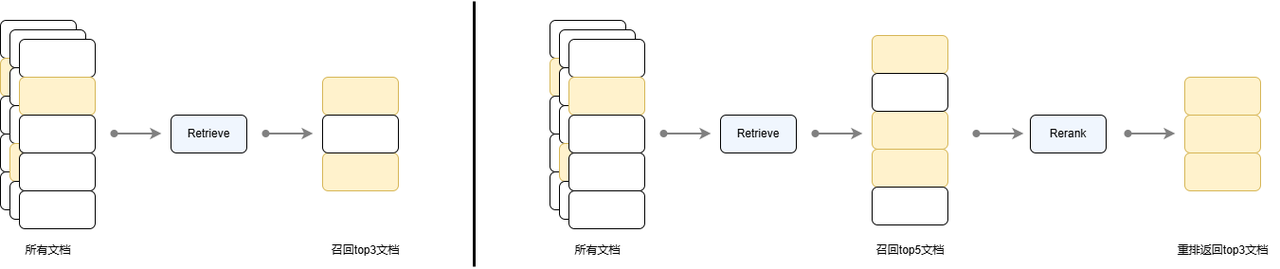

图4 单轮召回与召回重排策略流程对比

LazyLLM 提供了 Reranker 组件进行重排序，分别提供了在线和离线两种重排序模型的调用途径，其中在线模型通过OnlineEmbeddingModule(type="rerank") 进行调用，离线重排模型则仍然通过 TrainableModule 进行调用。使用 Reranker 时的可调整参数有：

* name (str, default: 'ModuleReranker' ) ： 实现重排序时必须为 ModuleReranker
* model（Union[Callable, str]) ： 实现重排序的具体模型名称或可调用对象
  * Callable 情形：
    * OnlineEmbeddingModule (type="rerank")：目前支持qwen和glm的在线重排序模型，使用前需要指定 apikey
    * TrainableModule(model="str")：需要传入本地模型名称，常用的开源重排序模型为bge-reranker系列
  * str 情形：模型名称，与上 Callable 情形 TrainableModule 对应的 model 参数要求相同
* topk（int）： 最终需要返回的 k 个节点数
* output\_format（str, default: None）：输出格式，默认为None，可选值有 'content' 和 'dict'，其中 content 对应输出格式为字符串，dict 对应字典
* join（boolean, default: False）：是否联合输出的 k 个节点，当输出格式为 content 时，如果设置该值为 True，则输出一个长字符串，如果设置为 False 则输出一个字符串列表，其中每个字符串对应每个节点的文本内容。

目前常用的开源重排序模型时 bge-reranker，可以通过 TrainableModule 启动相关服务并调用。在线模型服务商有qwen和glm提供了重排序模型服务，通过OnlineEmbeddingModule（type="rerank"）进行调用。

In [ ]:
from lazyllm import OnlineEmbeddingModule, TrainableModule
# 如果您要使用在线重排模型
# 目前 LazyLLM 支持 qwen和glm 在线重排模型，使用前请指定相应的 API key。
online_rerank = OnlineEmbeddingModule(type="rerank")
reranker = Reranker('ModuleReranker', model=online_rerank, topk=3)

# 启动本地重排序模型
offline_rerank = TrainableModule('bge-reranker-large').start()
reranker = Reranker('ModuleReranker', model=offline_rerank, topk=3)
# 或者直接传入模型名称使用本地重排序模型
reranker = Reranker('ModuleReranker', model='bge-reranker-large', topk=3)

下面我们实现一个例子，对上述 cosine 和 bm25 检索的 6 条结果取精排后的 top 2 文档。

In [ ]:
from lazyllm import Document, Retriever, Reranker, TrainableModule

# 定义嵌入模型和重排序模型
embedding_model = TrainableModule('bge-large-zh-v1.5').start()
offline_rerank = TrainableModule('bge-reranker-large').start()

docs = Document("/path/to/your/document", embed=embedding_model)
docs.create_node_group(name='block', transform=(lambda d: d.split('\n')))

# 定义检索器
retriever = Retriever(docs, group_name="block", similarity="cosine", topk=3)

# 定义重排器
# 指定 reranker1 的输出为字典，包含 content, embedding 和 metadata 关键字
# reranker = Reranker('ModuleReranker', model=online_rerank, topk=3, output_format='dict')
# 指定 reranker2 的输出为字符串，并进行串联，未进行串联时输出为字符串列表
reranker = Reranker('ModuleReranker', model=offline_rerank, topk=3, output_format='content', join=True)

# 执行推理
query = "猴面包树有哪些功效？"
result1 = retriever(query=query)
result2 = reranker(result1, query=query)

print("余弦相似度召回结果：")
print("\n\n".join([res.get_content() for res in result1]))
print("开源重排序模型结果：")
print(result2)

下表是针对查询“猴面包树有哪些功效？”的召回结果，注意到余弦相似度召回结果（第一列）的顺序并不包含相似度排序信息，通常是按照其在节点组内的相对位置进行返回，而进行一次重排序得到的结果如第二列所示，可见重排序后与查询更相似的文档被排在了在更前面的位置。

|  | **余弦相似度召回结果**                                                                                                                                                      | **重排结果**                                                                                                                                                                |
| --- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1 | 假苹婆 （学名：" "），别称七姐果、鸡冠皮、鸡冠木、山羊角、红郎伞、赛苹婆'及山木棉等，为梧桐科苹婆属半落叶乔木植物...                                                              | 猴面包树（学名：），又名-{zh-hant:猴面包树;zh-hans:猢狲树;zh-tw:猴面包树}-、非洲猴面包树、酸瓠树、猴树、旅人树、死老鼠树，是一种锦葵科猴面包树属的大型落叶乔木，原产于热带非洲... |
| 2 | 黄蝉（学名：'）别称为硬枝黄蝉、夹竹桃叶黄蝉、小花黄蝉、丛立黄蝉及黄兰蝉。为夹竹桃科黄蝉属植物...                                                                                 | 黄蝉（学名：'）别称为硬枝黄蝉、夹竹桃叶黄蝉、小花黄蝉、丛立黄蝉及黄兰蝉。为夹竹桃科黄蝉属植物...                                                                                  |
| 3 | 猴面包树（学名：），又名-{zh-hant:猴面包树;zh-hans:猢狲树;zh-tw:猴面包树}-、非洲猴面包树、酸瓠树、猴树、旅人树、死老鼠树，是一种锦葵科猴面包树属的大型落叶乔木，原产于热带非洲... | 假苹婆 （学名：" "），别称七姐果、鸡冠皮、鸡冠木、山羊角、红郎伞、赛苹婆'及山木棉等，为梧桐科苹婆属半落叶乔木植物...                                                              |

下表是在 CMRC 数据集上进行余弦相似度召回，是否启用重排序策略时召回文档的平均倒数排名（Mean Reciprocal Rank, MRR）对比。MRR用于评估检索组件返回结果的排序质量。具体计算方式如下：

* 对于每个查询 q，找到第一个相关上下文在返回结果中的排名$\text{rank}_i$
* 计算倒数排名$\frac{1}{\text{rank}_i}$
* MRR为所有查询的倒数排名的平均值：

$$
\text{MRR} = \frac{1}{N} \sum_{i=1}^N \frac{1}{\text{rank}_i}
$$

该值越接近1，表示检索组件返回的相关上下文排序越靠前。此处需要注意的是在没有使用重排序的情况下，当top k由1增长至5的过程中有明显下降的原因是检索器返回召回文段时不会进行排序，而是按节点组中节点的相对顺序进行返回。可见使用重排序策略后在提升召回率的同时提升了 MRR 指标，即重排序后的top 1 准确率可以达到 0.97.

表：使用重排序对召回结果的影响（MRR ↑）

| 方法                     | top 1<br>(recall = 0.94) | top 3<br>(recall = 0.97) | top 5<br>(recall = 0.98) |
|--------------------------|--------------------------|--------------------------|--------------------------|
| 按段落召回               | 0.9411                   | 0.6132                   | 0.4468                   |
| 按段落召回后重排序       | 0.9411                   | 0.9704                   | 0.9741                   |

## 综合所有优化的 RAG 实现

综合上述策略，我们可以得到多路召回 RAG ，即设置多个检索器在不同粒度进行检索或使用不同的相似度计算方法进行文档召回，再对所有检索器召回的文档进行排序得到最终上下文的方法。其流程如下图所示，这是一种比较标准的多路检索RAG架构，具有比朴素RAG更好的检索效果。

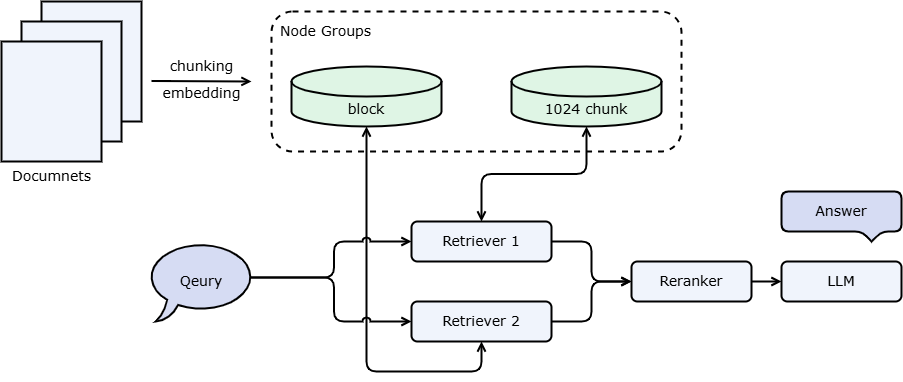

上述 RAG 流程的 LazyLLM 实现如下方代码块所示：

In [ ]:
import lazyllm

# 定义嵌入模型和重排序模型
# embedding_model = lazyllm.OnlineEmbeddingModule()
embedding_model = lazyllm.TrainableModule("bge-large-zh-v1.5").start()

# 如果您要使用在线重排模型
# 目前LazyLLM仅支持 qwen和glm 在线重排模型，请指定相应的 API key。
# online_rerank = lazyllm.OnlineEmbeddingModule(type="rerank")
# 本地重排序模型
offline_rerank = lazyllm.TrainableModule('bge-reranker-large').start()

docs = lazyllm.Document("/mnt/lustre/share_data/dist/cmrc2018/data_kb", embed=embedding_model)
docs.create_node_group(name='block', transform=(lambda d: d.split('\n')))

# 定义检索器
retriever1 = lazyllm.Retriever(docs, group_name="CoarseChunk", similarity="cosine", topk=3) 
retriever2 = lazyllm.Retriever(docs, group_name="block", similarity="bm25_chinese", topk=3)

# 定义重排器
reranker = lazyllm.Reranker('ModuleReranker', model=offline_rerank, topk=3)

# 定义大模型
llm = lazyllm.TrainableModule('internlm2-chat-20b').deploy_method(lazyllm.deploy.Vllm).start()

# prompt 设计
prompt = '你是一个友好的 AI 问答助手，你需要根据给定的上下文和问题提供答案。\
          根据以下资料回答问题：\
          {context_str} \n '
llm.prompt(lazyllm.ChatPrompter(instruction=prompt, extra_keys=['context_str']))

# 执行推理
query = "2008年有哪些赛事？"
result1 = retriever1(query=query)
result2 = retriever2(query=query)
result = reranker(result1+result2, query=query)

# 将query和召回节点中的内容组成dict，作为大模型的输入
res = llm({"query": query, "context_str": "".join([node.get_content() for node in result])})

print(f'Answer: {res}')

> 2008年有很多重要的赛事，以下是其中一些：
> 
> 1. \*\*2008年夏季奥林匹克运动会\*\*：在北京举行，共有来自204个国家和地区的11,032名运动员参加。共有302个小项，包括田径、游泳、篮球、足球、乒乓球等。
> 2. \*\*2008年NBA总决赛\*\*：波士顿凯尔特人队对阵洛杉矶湖人队，最终凯尔特人队以4比2的成绩获胜，赢得了他们的第17个NBA总冠军。
> 3. \*\*2008年F1世界锦标赛\*\*：包括多个分站赛，最终由刘易斯·汉密尔顿（Lewis Hamilton）赢得了他的首个世界冠军。
> 
> ...

[相关视频：video/7_1_rag.mp4](video/7_1_rag.mp4)

基于 LazyLLM 数据流实现上述流程的代码可以得到如下代码：

In [ ]:
import lazyllm
from lazyllm import bind

docs = lazyllm.Document("/path/to/your/document", embed=lazyllm.OnlineEmbeddingModule())
docs.create_node_group(name='block', transform=(lambda d: d.split('\n')))
prompt = "你是一个知识问答助手，请通过给定的文档回答用户问题。"

with lazyllm.pipeline() as ppl:
    with lazyllm.parallel().sum as ppl.prl:
        # CoarseChunk是LazyLLM默认提供的大小为1024的分块名
        ppl.prl.retriever1 = lazyllm.Retriever(doc=docs, group_name="block", similarity="bm25_chinese", topk=3)
        ppl.prl.retriever2 = lazyllm.Retriever(doc=docs, group_name="block", similarity="cosine", topk=3)

    ppl.reranker = lazyllm.Reranker(name='ModuleReranker',model=lazyllm.OnlineEmbeddingModule(type="rerank"), topk=3) | bind(query=ppl.input)

    ppl.formatter = (
        lambda nodes, query: dict(
            context_str = "".join([node.get_content() for node in nodes]),
            query = query,
        )
    ) | bind(query=ppl.input)

    ppl.llm = lazyllm.OnlineChatModule().prompt(lazyllm.ChatPrompter(instruction=prompt, extra_keys=['context_str']))
query = ""
ppl(query)

利用LazyLLM WebModule实现网页封装，在网页内进行问答。

In [ ]:
webpage = lazyllm.WebModule(ppl, port=23491).start().wait()

# 如果您在使用 Colab 等 jupyter 环境，请使用如下方式：
# webpage = lazyllm.WebModule(ppl, port=23466).start()
# 使用.stop（）停止上述应用，释放端口
# webpage.stop()

[相关视频 1 ：video/7_2_with.mp4](video/7_2_with.mp4)

[相关视频 2 ：video/7_2_with_web.mp4](video/7_2_with_web.mp4)

下面这个例子在上述多路召回的基础上新增了预置QA对，预置QA对是一种特殊的节点组，存储了大量预先提取的问题和答案，这些问答通常是由大模型进行提取。LazyLLM内置了预置QA对提取函数，可以直接使用。此外QA对节点组的使用与其他节点组有所不同，其他节点组一般都是直接在内容上进行检索然后返回对应内容，但是QA对的检索是检索阶段对Q（问题）进行相似度计算，最后和答案一起传给大模型。

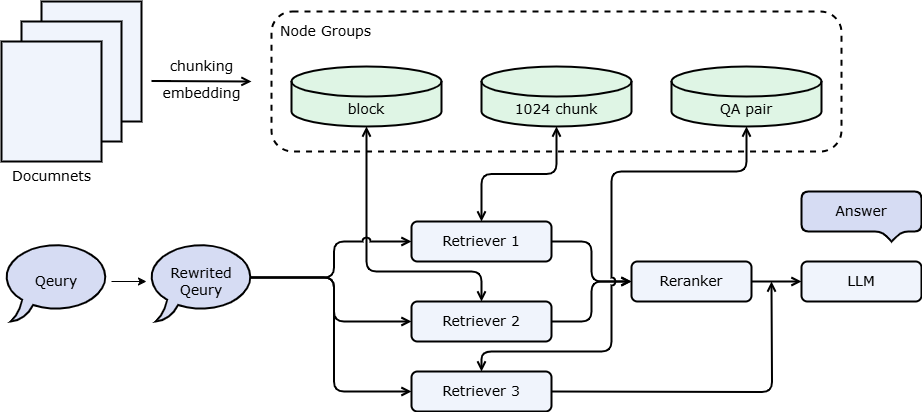

In [ ]:
import lazyllm
from lazyllm import bind

rewriter_prompt = "你是一个查询重写助手，负责给用户查询进行模板切换。\
          注意，你不需要进行回答，只需要对问题进行重写，使更容易进行检索\
          下面是一个简单的例子：\
          输入：RAG是啥？\
          输出：RAG的定义是什么？"
rag_prompt = '你是一个友好的 AI 问答助手，你需要根据给定的上下文和问题提供答案。\
                根据以下资料回答问题：\
                {context_str} \n '

# 定义嵌入模型和重排序模型
# online_embedding = lazyllm.OnlineEmbeddingModule()
embedding_model = lazyllm.TrainableModule("bge-large-zh-v1.5").start()

# 如果您要使用在线重排模型
# 目前LazyLLM仅支持 qwen和glm 在线重排模型，请指定相应的 API key。
# online_rerank = lazyllm.OnlineEmbeddingModule(type="rerank")
# 本地重排序模型
offline_rerank = lazyllm.TrainableModule('bge-reranker-large').start()

llm = lazyllm.OnlineChatModule(model="qwen2", base_url="http://10.119.24.121:25120/v1/", stream=True) # 访问 Vllm 启动的模型服务

qa_parser = lazyllm.LLMParser(llm, language="zh", task_type="qa")

docs = lazyllm.Document("/mnt/lustre/share_data/dist/cmrc2018/data_kb", embed=embedding_model)
docs.create_node_group(name='block', transform=(lambda d: d.split('\n')))
docs.create_node_group(name='qapair', transform=qa_parser)

def retrieve_and_rerank():
    with lazyllm.pipeline() as ppl:
        # lazyllm.parallel 并行执行两个检索操作
        with lazyllm.parallel().sum as ppl.prl:
            # CoarseChunk是LazyLLM默认提供的大小为1024的分块名
            ppl.prl.retriever1 = lazyllm.Retriever(doc=docs, group_name="CoarseChunk"，similarity="cosine", topk=3)
            ppl.prl.retriever2 = lazyllm.Retriever(doc=docs, group_name="block", similarity="bm25_chinese", topk=3)
        ppl.reranker = lazyllm.Reranker("ModuleReranker", model=offline_rerank, topk=3) | bind(query=ppl.input)
    return ppl

with lazyllm.pipeline() as ppl:
    # llm.share 表示复用一个大模型，如果这里设置为promptrag_prompt则会覆盖rewrite_prompt
    ppl.query_rewriter = llm.share(lazyllm.ChatPrompter(instruction=rewriter_prompt))
    with lazyllm.parallel().sum as ppl.prl:
        ppl.prl.retrieve_rerank = retrieve_and_rerank()
        # qa pair 节点组不与其他节点组一同参与重排序
        ppl.prl.qa_retrieve = lazyllm.Retriever(doc=docs, group_name="qapair", similarity="cosine", topk=3) 
    ppl.formatter = (
          lambda nodes, query: dict(
              context_str='\n'.join([node.get_content() for node in nodes]),
              query=query)
        ) | bind(query=ppl.input)
    ppl.llm = llm.share(lazyllm.ChatPrompter(instruction=rag_prompt, extra_keys=['context_str']))

lazyllm.WebModule(ppl, port=23491, stream=True).start().wait()

实际应用中，您也可以结合前端工程使用预置QA对实现问题推荐，例如用户提问了问题A，系统从预置QA对中找出与A相似的问题A’，作为推荐问题返回给用户，当用户点击对应问题时系统直接返回该问题的答案，而无需再次进行生成过程，不仅提高了用户的互动体验，还能有效减少系统的计算负担。

> 【注意】我们强烈建议您在学习进阶2使用向量数据库后使用预置QA对的策略进行调试，因为反复重启系统会耗费较长的时间和token。

## 附录1 LazyLLM中RAG的设计

### 3.1 文档的解析和构建

文档 ---(loader)--->document----(parser)--->node

其中最关键的函数是document.create\_node\_group(name, transform, parent)，其中name表示经过该parser得到的nodes的名字，transform表示由parent到name的转换规则，如果不指定则默认是根节点（origin）。具有相同name（即通过同一转换规则得到）的node视为一组nodes。下面给出一个例子：

假设原文有2句：

1. 你好，我是由商汤开发的人工智能机器人，我叫LazyLLM。我的使命是协助您，用最低的成本，构建最强大的大模型应用。现在，我们开始吧。
2. parallel的所有组件共享输入，并将结果合并输出。 parallel 的定义方法和 pipeline 类似，也可以直接在定义 parallel 时初始化其元素，或在with块中初始化其元素。

则origin nodes中有两个Node，即上面的2句话。我们假设id分别为1和2，​**这里只展示content和id，None的数据结构仅为示意，不是最终形式**​：

`all_nodes['origin'] = [Node(`​`id=0`​`, content='你好，我是由商汤开发的人工智能机器人，我叫LazyLLM。我的使命是协助您，用最低的成本，构建最强大的大模型应用。现在，我们开始吧。'), Node(`​`id=1`​`, content='parallel的所有组件共享输入，并将结果合并输出。 parallel 的定义方法和 pipeline 类似，也可以直接在定义 parallel 时初始化其元素，或在with块中初始化其元素。')]`

我们定义下面的一些parser

In [ ]:
document.create_node_group('block', lambda x: '。'.split(x))
document.create_node_group('doc-summary', summary_llm) # 假设我们有一个大模型能做summary
document.create_node_group('sentence', lambda x: '，'.split(x), parent='block')
document.create_node_group('block-summary', summary_llm, parent='block')
document.create_node_group('label', label_llm, parent='block') # 假设我们有一个大模型能提取label
document.create_node_group('count', lambda x: len(x), parent='sentence')

由上述的构建，我们得到了一棵关系树，如下图所示：

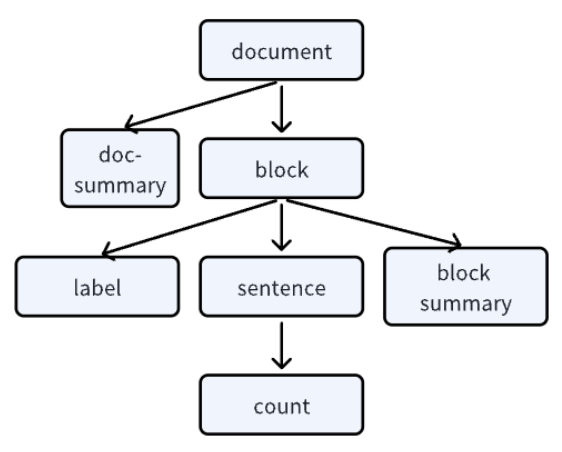

【注意】：每个document对象会有一个唯一的关系树，指明一组nodes与一组nodes之间的关系。

In [ ]:
all_nodes['block'] = [Node(id=0,  content='你好，我是由商汤开发的人工智能机器人，我叫LazyLLM', parent=0),
                      Node(id=1,  content='我的使命是协助您，用最低的成本，构建最强大的大模型应用', parent=0),
                      Node(id=2,  content='现在，我们开始吧', parent=0),
                      Node(id=3,  content='parallel的所有组件共享输入，并将结果合并输出', parent=1),
                      Node(id=4,  content='parallel 的定义方法和 pipeline 类似，也可以直接在定义 parallel 时初始化其元素，或在with块中初始化其元素', parent=1)
                     ]

In [ ]:
all_nodes['doc-summary'] = [Node(id=0,  content='LazyLLM的简介', parent=0),
                            Node(id=1,  content='parallel的定义和使用方式', parent=0), ]]

【注意】：create\_node\_group的transform规则是从一个Node到一个/多个组Node，并且会将所有的None变成平级，且会剔除content为空的Node。

In [ ]:
all_nodes['sentence'] = [Node(id=0, content='你好', parent=0),
                         Node(id=1, content='我是由商汤开发的人工智能机器人', parent=0),
                         Node(id=2, content='我叫LazyLLM', parent=0),
                         Node(id=3, content='我的使命是协助您', parent=1),
                         Node(id=4, content='用最低的成本', parent=1),
                         Node(id=5, content='构建最强大的大模型应用', parent=1),
                         Node(id=6, content='现在', parent=2),
                         Node(id=7, content='我们开始吧', parent=2),
                         Node(id=8, content='parallel的所有组件共享输入', parent=3),
                         Node(id=9, content='并将结果合并输出', parent=3),
                         Node(id=10, content='parallel 的定义方法和 pipeline 类似', parent=4),
                         Node(id=11, content='也可以直接在定义 parallel 时初始化其元素', parent=4),
                         Node(id=12, content='或在with块中初始化其元素', parent=4),
                        ]
all_nodes['block-summary'] = [Node(id=0, content='LazyLLM是谁', parent=0),
                              Node(id=1, content='LazyLLM的使命是什么', parent=1),
                              Node(id=2, content='开始', parent=2),
                              Node(id=3, content='parallel的流程', parent=3),
                              Node(id=4, content='parallel的定义方式', parent=4)
                             ]
all_nodes['label'] = [Node(id=0, content='商汤，机器人', parent=0),
                      Node(id=1, content='大模型应用', parent=1),
                      Node(id=2, content='开始', parent=2),
                      Node(id=3, content='共享输入', parent=3),
                      Node(id=4, content='初始化，with', parent=4),

count也类似，这里不再赘述。

### 3.2 文档的召回

每次召回时，会选择一组nodes（根据name），一个相似度计算公式（bm25 / ​**cosine**​），一个索引策略（​**default**​/map/tree等），以及topk。

In [ ]:
Retriever(documents, parser/nodes='Sentence', similarity='chinese_bm25', index='default', topk=6)

在召回时，如果发现没有对应的nodes，则会根据注册的变换规则（parser）创建对应的nodes。特别的，如果相似度计算公式表示自己需要embedding，但我们没有对nodes做embedding，也会对这一组nodes做一次embedding。

我们允许用户以某种方法注册similarity，注册时要指定它用的是原文还是embedding后的结果。

【注意】​**召回时只会对给定的nodes进行召回**​，不会查询它的父子关系，去找它的关联节点。

和llamaindex不同，index在我们这里只是一个索引方式，不涉及存储。

* index为default 时，我们会遍历一组nodes下所有的node，分别计算相似度，然后取topk；
* index为map时，我们会从一个hash-map中查表，直接得到所有匹配的node，此时similarity和topk会失效。

【注意】这个hash-map需要放到store中，以提高后续的查找效率。

### 3.3 关联节点查找

DocNode 是 LazyLLM 存储文档片段的对象，召回器和重排器返回的都是 DocNode，因此认识 DocNode 对象有重要实践意义。DocNode 有如下公共属性：

> text：原文
> 
> embedding：原文对应的向量表示
> 
> parent：当前节点的父节点
> 
> children：当前节点的子节点
> 
> root\_node：当前节点对应的 Origin 祖先节点
> 
> metadata：节点元数据，包含文件路径、文件格式等信息
> 
> global\_metadata：全局元数据
> 
> doc\_path：源文件路径

根据上述信息可知，每一个 DocNode 都保存了对应的原文片段、嵌入信息和元数据，除此之外还记录了它在整个节点树中的父子关系，由此，我们可以轻松实现从一个节点找到其他关联节点。LazyLLM提供`document.find('Sentence')(nodes)`接口实现这一功能：从给定的召回到的nodes找到其关联的祖先节点或子孙节点。以上面例子中的block-1和block-3为例：

（1）如果我们想要找原文（origin，父节点），则`block-1`对应`origin-0`，`block-3`对应`origin-1`，于是结果为`[origin-0, origin-1]`

（2）如果我们要找子孙节点，则会找到其关联的全部节点。例如我们想找句子（sentence）。`block-1`对应`[3, 4, 5]`，`block-3`对应`[8, 9]`，于是结果为`[sentence-3, sentence-4, sentence-5, sentence-8, sentence-9]`

## 附录2 自定义 Transform

在做 RAG 应用时，首先需要做的就是对文档进行解析，把整个文档解析成适合后面检索召回的处理的片段，然后再输入给 LLM 用于生成答案回复。LazyLLM 提供的默认 `NodeTransform` 是 `SentenceSplitter`，用于把文档解析成句子进行处理。如果 LazyLLM 提供的 `SentenceSplitter` 不能满足要求，可以根据需求自己定义满足需求的 Transform 算法。这个 Transform 算法可以是 function 类型也可以是 class类型。下面我们分别进行讲解。

### 基于 function 的自定义

如果我们的 Transform 算法比较简单，我们可以定义一个 function，代码如下:

In [ ]:
def SentSplitter(text: str, splitter: str="\n"):
    if text== '':
        return ['']
    paragraphs = text.split(splitter)
    return [para for para in paragraphs]

这个 Transform 函数逻辑比较简单，传入的参数是字符串，分隔符是 '\\n'，然后把分割后的字符串以字符串列表的形式返回。然后我们怎么使用呢？其实使用起来也很简单，在 Document 创建 node group 的时候把上面自定义的 `SentSplitter` 传给 transform 参数即可。代码如下:

In [ ]:
import lazyllm
from lazyllm import Retriever
from lazyllm.tools.rag import Document, DocNode

def SentSplitter(text: str, splitter: str="\n"):
    if text == '':
        return ['']
    paragraphs = text.split(splitter)
    return [para for para in paragraphs]

prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task. In this task, you need to provide your answer based on the given context and question.'
documents = Document(dataset_path="rag_master", embed=lazyllm.OnlineEmbeddingModule(source="glm", embed_model_name="embedding-2"), manager=False)
documents.create_node_group(name="sentences", transform=SentSplitter)

ppl = Retriever(documents, group_name="sentences", similarity="cosine", topk=3)
print(ppl("何为天道"))

这里我们以国学的数据集为例进行说明，数据集的下载方式是：[【数据集下载方式】](https://huggingface.co/datasets/LazyAGI/Chinese_Classics_Articles/tree/main)。

结果输出为:

```bash
[<Node id=76bba733-552d-4d84-a065-c122220e8c5c>, <Node id=647792e4-f2b5-44e0-8ee9-0c397da7dd3e>, <Node id=d2acf2cd-add0-4085-9358-51d3c701c430>]
```

结果输出为三个 Node 节点，符合预期。

到这里有人可能会问，前面讲解自定义 Reader 的时候，返回值是 `List[Node]` 类型。那如果入参的类型是 `Node` 怎么办？或者我怎么知道传入函数的参数类型是什么呢？其实答案很简单。自定义 Transform 算法函数的参数可以由开发者自己指定，非常灵活。这里详细说明一下。如果定义的函数入参是 `str` 类型，那么在使用的时候往 `create_node_group` 中传入函数时，可以只指定 `transform` 为 `SentSplitter`，也可以在指定 `transform` 的时候，也显示的指定 `trans_node` 为 `False`。如果定义的函数入参是 `DocNode` 类型，那么在使用的时候需要同时指定 `transform` 为 `SentSplitter` 和 `trans_node` 为 `True`。对于函数的输出参数可以是 `List[str]` 类型，也可以是 `List[Node]` 类型。

为了对这块了解的更清楚一些，我们以上面代码为例进行演示。首先在 `SentSplitter` 中打印一下入参的类型，代码如下:

In [ ]:
def SentSplitter(text: str, splitter: str="\n"):
    print(f"text: {type(text)}")
    if text == '':
        return ['']
    paragraphs = text.split(splitter)
    return [para for para in paragraphs]

其他代码不变，然后再运行一下上面的代码，结果输出为:

```bash
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
[<Node id=57d77052-6170-4f1c-af6b-9fad32483250>, <Node id=606c8ad2-cfae-4f6d-8730-3cf81f3d2df7>, <Node id=3e002fb9-b38f-4a92-91f1-f153b0d829a0>]
```

结果显示进入 `SentSplitter` 的参数类型是字符串。下面我们再修改一下 `create_node_group` 中的 `trans_node` 的值为 `True`，看一下效果，代码如下:

In [ ]:
prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task. In this task, you need to provide your answer based on the given context and question.'
documents = Document(dataset_path="rag_master", embed=lazyllm.OnlineEmbeddingModule(source="glm", embed_model_name="embedding-2"), manager=False)
documents.create_node_group(name="sentences", transform=SentSplitter, trans_node=True)

ppl = Retriever(documents, group_name="sentences", similarity="cosine", topk=3)
print(ppl("何为天道"))

结果输出为:

```bash
text: <class 'lazyllm.tools.rag.doc_node.DocNode'>
```

然后就报错了:

```bash
'DocNode' object has no attribute 'split'
```

因为传入的参数是 `Node` 类型了，所以不能直接使用 `split` 函数了。符合预期。

下面我们稍微修改一下 `SentSplitter`，使其输出类型是 `List[Node]` 类型。代码如下:

In [ ]:
def SentSplitter(text: str, splitter: str="\n"):
    print(f"text: {type(text)}")
    if text == '':
        return ['']
    paragraphs = text.split(splitter)
    return [DocNode(content=para) for para in paragraphs if para]

我们以入参为 `str` 类型，出参为 `List[Node]` 类型为例。结果输出如下:

```bash
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
text: <class 'str'>
[<Node id=5dc6d20c-f93c-4da8-8a8f-7f4bbb5efe6b>, <Node id=ef918c09-5e12-4b04-864f-9f2a13393ab8>, <Node id=1ba22c8a-f16a-4ef7-afe7-a8808a05d308>]
```

可见如果 Transform 算法是以 function 的形式定义的，那么函数的入参可以是 `str` 类型，也可以是 `Node` 类型，出参可以是 `List[str]` 类型，也可以是 `Node` 类型，非常灵活。

### 基于 class 的自定义

如果自定义的 Transform 算法很复杂的话，这时候一个 function 就不能简单的解决了。这时候就可以使用基于 class 的方式进行定义。首先定义的类要继承自 `NodeTransform` 基类，然后重写基类的 `transform` 方法即可。这里需要注意的是，因为是继承自 `NodeTransform` 基类，所以 `transform` 函数的入参只能是 Node 类型，而不能是 `str` 类型，但是它的出参可以是 `List[str]` 类型，也可以是 `List[Node]` 类型。这里我们简单定义一个以 '\\n\\n' 为分隔符的 Transform 算法。代码如下:

In [ ]:
from lazyllm.tools.rag import DocNode, NodeTransform
from typing import List

class ParagraphSplitter(NodeTransform):
    def __init__(self, splitter: str = r"\n\n", num_workers: int = 0):
        super(__class__, self).__init__(num_workers=num_workers)
        self.splitter = splitter

    def transform(self, node: DocNode, **kwargs) -> List[str]:
        return self.split_text(node.get_text())

    def split_text(self, text: str) -> List[str]:
        if text == '':
            return ['']
        paragraphs = text.split(self.splitter)
        return [para for para in paragraphs]

在上面的代码中，基础接口是 transform，具体处理方法是在 split\_text 方法中实现的。

然后我们修改一下上面注册 Transform 的代码，只要把参数 `transform` 替换为 `ParagraphSplitter`，同时 `trans_node` 不设置即可。代码如下:

In [ ]:
from lazyllm.tools.rag import Document
import lazyllm
from lazyllm import Retriever

prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task. In this task, you need to provide your answer based on the given context and question.'
documents = Document(dataset_path="rag_master", embed=lazyllm.OnlineEmbeddingModule(source="glm", embed_model_name="embedding-2"), manager=False)
documents.create_node_group(name="sentences", transform=ParagraphSplitter)

ppl = Retriever(documents, group_name="sentences", similarity="cosine", topk=3)
print(ppl("何为天道"))

结果输出为：

```bash
[<Node id=ea8e0a58-8d9b-45ab-aefd-9f9b900b40a5>, <Node id=7c801606-40da-45a8-874d-c9892be3fbed>, <Node id=f73f95ac-a239-4bd9-b405-4b1763a170bf>]
```

结果输出为三个 node，符合预期。

然后我们再修改一下 `ParagraphSplitter` 的出参类型，代码如下:

In [ ]:
class ParagraphSplitter(NodeTransform):
    def __init__(self, splitter: str = r"\n\n", num_workers: int = 0):
        super(__class__, self).__init__(num_workers=num_workers)
        self.splitter = splitter

    def transform(self, node: DocNode, **kwargs) -> List[str]:
        return self.split_text(node.get_text())

    def split_text(self, text: str) -> List[str]:
        if text == '':
            return ['']
        paragraphs = text.split(self.splitter)
        return [DocNode(content=para) for para in paragraphs]

然后再重新运行一下上面的代码，结果输出为:

```bash
[<Node id=47e06bc6-52ed-411d-a7a1-4da345f32700>, <Node id=0fdc7cfb-e0c4-411a-945d-007fbf4e68f0>, <Node id=7593f017-e285-49d7-bbd5-2177e691919c>]
```

所以基于 class 的 Transform 算法的入参只能是 `Node` 类型，但是出参可以是 `List[str]` 类型，也可以是 `List[Node]` 类型。

## 使用自定义 Transform 搭建 RAG 应用

这里我们就以前面基于 class 定义的 Transform 为例搭建一个国学大师的 RAG 对话机器人了。代码如下:

In [ ]:
import lazyllm
from lazyllm import pipeline, parallel, bind, Retriever, Reranker
from lazyllm.tools.rag import Document

prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task. In this task, you need to provide your answer based on the given context and question.'
documents = Document(dataset_path="rag_master", embed=lazyllm.TrainableModule("bge-large-zh-v1.5"), manager=False)
documents.create_node_group(name="paragraphs", transform=ParagraphSplitter)

with pipeline() as ppl:
    with parallel().sum as ppl.prl:
        prl.retriever1 = Retriever(documents, group_name="paragraphs", similarity="cosine", topk=3)
        prl.retriever2 = Retriever(documents, "CoarseChunk", "bm25_chinese", 0.003, topk=3)
    ppl.reranker = Reranker(name="ModuleReranker", model='bge-reranker-large', topk=1, output_format="content", join=True) | bind(query=ppl.input)
    ppl.formatter = (lambda nodes, query: dict(context_str=nodes, query=query)) | bind(query=ppl.input)
    ppl.llm = lazyllm.TrainableModule("internlm2_5-7b-chat").prompt(lazyllm.ChatPrompter(prompt, extra_keys=["context_str"]))

lazyllm.WebModule(ppl, port=23456).start().wait()

在上面的实现代码中，我们通过 Lazyllm 中的 TrainableModule 使用本地模型来搭建的基于 RAG 的对话机器人。首先定义 prompt 和 document，在创建 node\_group 时，可以通过参数 transform 把自定义的ParagraphSplitter 配置进去，用于后面对文档的处理。

在接下来的代码中，通过 pipeline 定义了 RAG 的处理流程。首先是定义了两个 Retriever 对文档处理，这两个 Retriever 通过 parallel 进行并行处理。然后定义 Reranker，对检索到的文档进行重排序。接下来对重排序的文档和输入 query 进行格式化处理，处理完之后再输送给 LLM，使 LLM 根据检索到文档生成理想的答案。最后以创建的 pipeline 为基础启动了一个 WebModule，根据启动后对应的 ip 和 port 可以在浏览器中打开并进行使用体验。

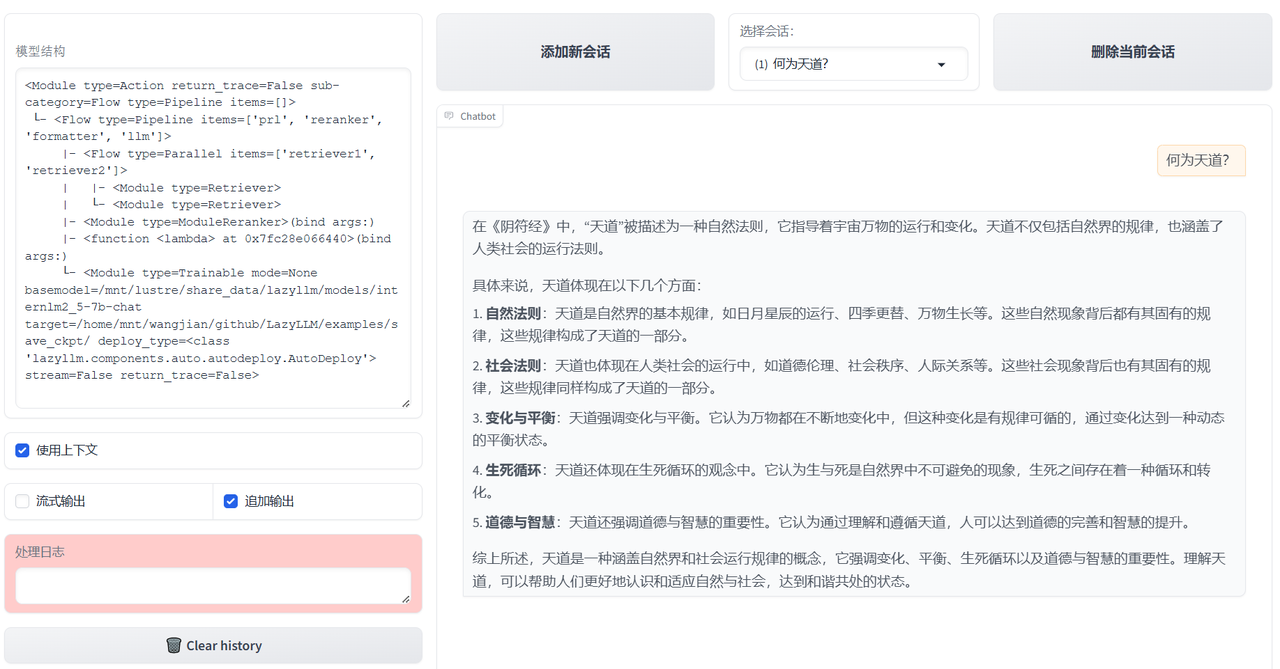

这是使用体验的样例截图，rag 的文档库是部分国学资料，包括中庸、大学、心经、论语、道德经和阴符经。提问的问题是 “何为天道？”，下面的回复是 LLM 基于上面自定义的 nodeParser 检索出的文档进行生成的结果。